In [1]:
# Import
from __future__ import absolute_import, division, print_function

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)
tf.enable_eager_execution()

1.13.1


In [2]:
# Load Data 
filename = 'C:\\Users\\deniz\\Desktop\\Thesis of ML for AutoPas\\Data\\Batch5\\half5.txt'
arr = np.genfromtxt(filename, delimiter=',')
print(arr.shape)

(12487, 540)


In [3]:
# Define how many parameters you have (it is assumed that the rest are classes)
parameter_count = arr.shape[1] - 23
print(parameter_count)

517


In [4]:
print(np.ceil(arr.shape[0] * 4 / 5))

9990.0


In [6]:
#This part is for handling a picture

In [408]:
# Copy the array
data = np.copy(arr)

# Shuffle data and take 25% as test data
np.random.shuffle(data)
test_size = (np.ceil(data.shape[0] * 99 / 100)).astype(int)
train_params = data[test_size:,4:516]
train_labels = np.argmin(data[test_size:,-23:-3], 1).astype(int)
test_params = data[:test_size,4:516]
test_labels = np.argmin(data[:test_size,-23:-3], 1).astype(int)

# Posible normalization functions
def normalize03(array):
    divisor = np.std(array)
    sub = np.mean(array)
    for i in range(array.size):
        array[i] = (array[i] - sub) / divisor
        
def normalize04(array):
    divisor = np.std(array)**2
    for i in range(array.size):
        array[i] = array[i]**2 / divisor
        
# Normalize the data along the other axis, because now the parameters of a picture are related to each other
np.apply_along_axis(normalize02, 0, train_params)
np.apply_along_axis(normalize02, 0, test_params)
print(train_params[0])

[0.    0.25  0.    0.028]


In [395]:
# This code block samples 100 of each type of result
print(data[:,0:4].shape, np.argmin(data[:,-23:], 1).astype(int).shape)
labs = np.argmin(data[:,-23:], 1).astype(int)
print(data[:,0:4].shape, labs.reshape(labs.shape[0], 1).shape)
training = np.concatenate((data[:,0:4], labs.reshape(labs.shape[0], 1)), axis=1)
np_sorted = training[training[:,4].argsort()]
#np_sorted = np.sort(training, axis=0)

final_training = np.concatenate((np_sorted[:100], np_sorted[649:749], np_sorted[784:884], np_sorted[1060:1160], \
                                 np_sorted[1196:1296], np_sorted[1535:1635], np_sorted[2043:2143], np_sorted[11619:11719]))

test_size = (np.ceil(data.shape[0] * 99 / 100)).astype(int)
train_params = final_training[:,0:4]
train_labels = final_training[:,4].astype(int)
test_params = data[:,0:4]
test_labels = np.argmin(data[:,-23:], 1).astype(int)

np.apply_along_axis(normalize02, 0, train_params)
np.apply_along_axis(normalize02, 0, test_params)
print(train_params[0])

# Check how the training data is distributed among the labels
dist = np.bincount(final_training[:,4].astype(int))
print(dist)
print(np.argmax(dist))
print(np.max(dist) / final_training.shape[0])

(12487, 4) (12487,)
(12487, 4) (12487, 1)
[0.5   0.    0.5   0.008]
[100   0 100   0 100   0   0 100   0   0   0 100   0 100   0   0   0   0
   0   0 100   0 100]
0
0.125


In [5]:
# This code block generates statistics using the picture
picture_raw = np.copy(arr)

picture = picture_raw[:, 4:516]
particles = picture_raw[:,3]
box_length = picture_raw[:,2]
cutoff = picture_raw[:,1]
v_skin_rad = picture_raw[:,0]
average = picture_raw[:,516] #this should always equal particles / box_length**3
results = picture_raw[:, 517:]

# This function takes a picture and generates its statistics
def stat_maker(input):
    most_crowded = np.max(input)
    # X percent of cells have less than 1 per cent of particles compared to the most crowded cell
    most_1 = 0
    # X percent of cells have more than 50 percen of particles compared to the most crowded cell
    least_90 = 0
    # X percent of cells have more than 90 percent of particles compared to the most crowded cell
    least_50 = 0
    for i in input:
        if i < most_crowded * 0.01:
            most_1 += 1
        if i > most_crowded * 0.50:
            least_50 += 1
        if i > most_crowded * 0.90:
            least_90 += 1
    return (most_crowded, most_1, least_50, least_90)
            
# This function calculates the crowdedness the most crowded cutoff region
# rounded up to a multipe of cell count if cutoff region doesn't fit
# assumption: cutoff cannot be bigger than box length
def main_load(input):
    picture = input[0:512]
    cutoff = input[512]
    box_length = input[513]
    cells_per_dimension = 8
    dimension_length = box_length / cells_per_dimension
    cells_per_cutoff = np.ceil(cutoff / dimension_length).astype(int)
    
    max_value = 0
    counted_fields = 0
    for x in range(cells_per_dimension - cells_per_cutoff + 1):
        for y in range(cells_per_dimension - cells_per_cutoff + 1):
            for z in range(cells_per_dimension - cells_per_cutoff + 1):
                current_value = 0
                for x_cut in range(cells_per_cutoff):
                    for y_cut in range(cells_per_cutoff):
                        for z_cut in range(cells_per_cutoff):
                            current_value += picture[x + x_cut + (y + y_cut) * cells_per_dimension
                                                  + (z + z_cut) * cells_per_dimension]
                if current_value > max_value:
                    max_value = current_value
                counted_fields += 1
    return max_value
                
#for i in range(picture_raw.shape[0]):
#    print(particles[i], cutoff[i], box_length[i])
#    print(stat_maker(picture[i]))
#    print(main_load(picture[i], cutoff[i], box_length[i], 8))

pre_stats = np.stack((cutoff, box_length), 1)
pre_stats = np.concatenate((picture, pre_stats), 1).astype(int)
ml_result = np.apply_along_axis(main_load, 1, pre_stats)
sm_result = np.apply_along_axis(stat_maker, 1, picture)

stat_data = np.concatenate((np.stack((particles, box_length, cutoff, v_skin_rad, average), 1), sm_result), 1)
stat_data = np.concatenate((stat_data, ml_result.reshape(ml_result.shape[0], 1)), 1)

In [6]:
print(stat_data[:5])

[[1.33100e+03 4.00000e+00 1.00000e+00 1.00000e-01 2.07969e+01 3.10000e+01
  3.08000e+02 2.60000e+01 2.00000e+00 1.47000e+02]
 [1.33100e+03 4.00000e+00 1.00000e+00 2.00000e-01 2.07969e+01 3.10000e+01
  3.08000e+02 2.60000e+01 2.00000e+00 1.47000e+02]
 [1.33100e+03 4.00000e+00 1.00000e+00 3.00000e-01 2.07969e+01 3.10000e+01
  3.08000e+02 2.60000e+01 2.00000e+00 1.47000e+02]
 [1.33100e+03 4.00000e+00 2.00000e+00 1.00000e-01 1.66375e+02 3.10000e+01
  3.08000e+02 2.60000e+01 2.00000e+00 6.50000e+02]
 [1.33100e+03 4.00000e+00 2.00000e+00 2.00000e-01 1.66375e+02 3.10000e+01
  3.08000e+02 2.60000e+01 2.00000e+00 6.50000e+02]]


In [7]:
#This part is for handling a picture

In [26]:
# Copy the array
data = np.copy(arr)
data = np.concatenate((stat_data, data[:, 517:]), 1)
parameter_count = 10

# Shuffle data and take 80% as test data
np.random.shuffle(data)
test_size = (np.ceil(data.shape[0] / 4)).astype(int)
train_params = data[test_size:,0:parameter_count]
train_labels = np.argmin(data[test_size:,parameter_count:], 1).astype(int)
test_params = data[:test_size,0:parameter_count]
test_labels = np.argmin(data[:test_size,parameter_count:], 1).astype(int)


# Posible normalization functions
def normalize01(array):
    divisor = np.max(array)
    for i in range(array.size):
        array[i] = array[i] / divisor
        
def normalize02(array):
    divisor = np.max(array) - np.min(array)
    sub = np.min(array)
    for i in range(array.size):
        array[i] = (array[i] - sub) / divisor
        
def normalize03(array):
    for i in range(array.size):
        array[i] = np.log(array[i])
        
# Normalize the data
np.apply_along_axis(normalize03, 0, train_params[:,0])
np.apply_along_axis(normalize03, 0, test_params[:,0])

np.apply_along_axis(normalize03, 0, train_params[:,4:6])
np.apply_along_axis(normalize03, 0, test_params[:,4:6])

np.apply_along_axis(normalize03, 0, train_params[:,9])
np.apply_along_axis(normalize03, 0, test_params[:,9])

np.apply_along_axis(normalize02, 0, train_params)
np.apply_along_axis(normalize02, 0, test_params)
print(train_params[:10])

[[0.37634211 0.         0.66666667 0.         0.84594232 0.34215078
  0.02580645 0.10843373 0.02083333 0.69384468]
 [0.05991478 0.         0.33333333 0.         0.52428097 0.04078889
  0.14516129 0.1686747  0.0625     0.5607343 ]
 [0.2580085  0.5        0.66666667 0.         0.60456018 0.15811476
  0.00322581 0.28313253 0.0625     0.52476129]
 [0.66751524 0.         0.66666667 0.         0.96394278 0.41151852
  0.00322581 0.85542169 0.0625     0.87757791]
 [0.59232218 0.5        0.66666667 1.         0.74004372 0.40415676
  0.00322581 0.3935743  0.10416667 0.64353648]
 [0.         0.         0.66666667 0.         0.69342639 0.02152982
  0.19677419 0.12851406 0.02083333 0.63261106]
 [0.41166193 0.5        0.33333333 0.5        0.47340316 0.24760034
  0.00322581 0.51807229 0.10416667 0.4849705 ]
 [0.61830963 0.         0.66666667 1.         0.94400177 0.35893249
  0.00322581 0.95582329 0.1875     0.86352747]
 [0.21356821 0.         0.66666667 0.         0.77997677 0.1482317
  0.00645161 

In [7]:
# Current hacky model with 4 paramters

data = np.stack((particles, box_length, cutoff, v_skin_rad), 1)
print(data.shape, results.shape)
data = np.concatenate((data, results), 1)
parameter_count = 4

# Shuffle data and take 80% as test data
np.random.shuffle(data)
test_size = (np.ceil(data.shape[0] / 4)).astype(int)
train_params = data[test_size:,0:parameter_count]
train_labels = np.argmin(data[test_size:,parameter_count:], 1).astype(int)
test_params = data[:test_size,0:parameter_count]
test_labels = np.argmin(data[:test_size,parameter_count:], 1).astype(int)


# Posible normalization functions
def normalize01(array):
    divisor = np.max(array)
    for i in range(array.size):
        array[i] = array[i] / divisor
        
np.apply_along_axis(normalize01, 0, train_params)
np.apply_along_axis(normalize01, 0, test_params)
print(train_params[:10])

(12487, 4) (12487, 23)
[[0.0264296  0.66666667 1.         0.66666667]
 [0.02116101 0.33333333 0.25       1.        ]
 [0.03945176 0.33333333 0.75       0.66666667]
 [0.02116101 1.         0.25       1.        ]
 [0.28694027 0.66666667 0.5        0.33333333]
 [0.04732092 1.         0.25       0.33333333]
 [0.13314969 0.66666667 0.25       1.        ]
 [0.26005798 1.         0.75       0.66666667]
 [0.37856737 1.         0.75       0.66666667]
 [0.15049652 0.33333333 0.75       0.66666667]]


In [25]:
print(train_params[:25,0])

[1.         0.33333333 0.5       ]


In [33]:
# Check how the total data is distributed among the labels
dist = np.bincount(np.concatenate((train_labels, test_labels)))
print(dist)
print(np.argmax(dist))
print(np.max(dist) / data.shape[0])

[ 605   44  135    0  276    0    0  112    0   23    1  255   84  411
    0   34    0   63    0    0 9576    0  868]
20
0.766877552654761


In [8]:
# Model
model = keras.Sequential([
    #keras.layers.Dense(parameter_count, activation=tf.nn.relu),
    keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(4,)),
    keras.layers.Dense(23, activation=tf.nn.softmax)
])

opt = keras.optimizers.Adam(lr=0.001)

model.compile(optimizer=opt, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
# Fun
model.fit(train_params, train_labels , epochs=50)

Epoch 1/50
9365/9365 [==============================] - 1s 126us/sample - loss: 1.5632 - acc: 0.7626
Epoch 2/50
9365/9365 [==============================] - 1s 67us/sample - loss: 1.0263 - acc: 0.7663
Epoch 3/50
9365/9365 [==============================] - 1s 68us/sample - loss: 0.9861 - acc: 0.7663
Epoch 4/50
9365/9365 [==============================] - 1s 72us/sample - loss: 0.9518 - acc: 0.7663
Epoch 5/50
9365/9365 [==============================] - 1s 63us/sample - loss: 0.9188 - acc: 0.7663
Epoch 6/50
9365/9365 [==============================] - 1s 81us/sample - loss: 0.8878 - acc: 0.7663
Epoch 7/50
9365/9365 [==============================] - 1s 68us/sample - loss: 0.8611 - acc: 0.7663
Epoch 8/50
9365/9365 [==============================] - 1s 73us/sample - loss: 0.8375 - acc: 0.7663
Epoch 9/50
9365/9365 [==============================] - 1s 73us/sample - loss: 0.8179 - acc: 0.7663
Epoch 10/50
9365/9365 [==============================] - 1s 88us/sample - loss: 0.8015 - acc: 0.766

In [10]:
predictions = model.predict(test_params)
test_loss, test_acc = model.evaluate(test_params, test_labels)
print('Test accuracy:', test_acc)

3122/3122 [==============================] - 0s 76us/sample - loss: 0.6799 - acc: 0.7947
Test accuracy: 0.7946829


In [11]:
# Print prediction, result, and how certain the result is
best = np.argsort(predictions)
print(' Best  Guess1  Guess2  Certainty1      Certainty2')
for i in range(20):
    print(' ', test_labels[i], '\t', best[i][-1], '\t', best[i][-2], '\t', \
          "{:.2%}".format(predictions[i][best[i][-1]]), '\t', "{:.2%}".format(predictions[i][best[i][-2]]))

 Best  Guess1  Guess2  Certainty1      Certainty2
  20 	 20 	 0 	 79.52% 	 7.94%
  20 	 20 	 22 	 78.13% 	 14.58%
  20 	 20 	 0 	 79.11% 	 13.01%
  20 	 20 	 0 	 85.90% 	 8.29%
  20 	 20 	 22 	 69.64% 	 22.33%
  20 	 20 	 22 	 75.66% 	 16.07%
  4 	 4 	 20 	 64.41% 	 16.79%
  20 	 20 	 22 	 93.24% 	 3.27%
  22 	 20 	 0 	 83.42% 	 9.78%
  20 	 20 	 22 	 74.11% 	 17.94%
  22 	 22 	 20 	 27.31% 	 26.57%
  22 	 20 	 22 	 83.46% 	 9.39%
  20 	 20 	 0 	 88.94% 	 7.61%
  20 	 20 	 7 	 90.59% 	 3.27%
  20 	 20 	 22 	 85.62% 	 8.08%
  20 	 20 	 22 	 78.98% 	 13.79%
  0 	 20 	 22 	 80.89% 	 10.16%
  0 	 4 	 20 	 62.80% 	 18.86%
  20 	 20 	 22 	 79.34% 	 13.44%
  22 	 13 	 20 	 32.47% 	 28.26%


In [12]:
# Print general statistics about in how many guesses the AI would be correct
correct = np.zeros(best.shape[1])
most_occuring = np.sort(np.bincount(test_labels))[::-1]
for i in range(test_size):
    for j in range(correct.size):
        if best[i][-j-1] == test_labels[i]:
            correct[j] = correct[j] + 1
            break
np.set_printoptions(precision=3)
print('The count of guesses until correct choice:', correct.astype(int))
print('Cumilative chance that the choice was correct by:', \
      np.apply_along_axis(lambda x: x / test_size, 0, np.cumsum(correct))[0:5])
print('The count of most occuring tests:', most_occuring)
print('Cumilative chance that the choice was correct by:', \
      np.apply_along_axis(lambda x: x / test_size, 0, np.cumsum(most_occuring))[0:5])

The count of guesses until correct choice: [2481  277  221   79   22   19   12    2    9    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]
Cumilative chance that the choice was correct by: [0.795 0.883 0.954 0.98  0.987]
The count of most occuring tests: [2400  220  156  102   74   71   24   22   17   11   10   10    5    0
    0    0    0    0    0    0    0    0    0]
Cumilative chance that the choice was correct by: [0.769 0.839 0.889 0.922 0.946]


In [17]:
# Display relative timing of all experiments, and print the ones which are relatively close
timings = np.apply_along_axis(lambda x: np.sort(x), 1, arr[:, parameter_count:])
for i in range(timings.shape[0]):
    fastest = timings[i][0]
    for j in range(timings.shape[1]):
        timings[i][j] = timings[i][j] / fastest

for i in range(3):
    print(timings[i])
    
print('The average:', np.average(timings, 0))

count = 0
for i in range(timings.shape[0]):
    if timings[i][1] < 1.01:
        count = count + 1
print(count, 'second best results from', timings.shape[0], 'are within 1 percent speed difference')

count = 0
for i in range(timings.shape[0]):
    for j in range(1, timings.shape[1]):
        if timings[i][j] < 1.01:
            count = count + 1
print(count, 'non best results from', timings.shape[0], 'are within 1 percent speed difference')


count = 0
for i in range(timings.shape[0]):
    if timings[i][1] < 1.05:
        count = count + 1
print(count, 'second best results from', timings.shape[0], 'are within 5 percent speed difference')

C:\Users\deniz\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\deniz\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan na

0 non best results from 12487 are within 1 percent speed difference
0 second best results from 12487 are within 5 percent speed difference


In [370]:
# Count the first guesses that were relatively quick
test_timings = data[:test_size,parameter_count:]
for i in range(test_timings.shape[0]):
    fastest = np.min(test_timings[i])
    for j in range(test_timings.shape[1]):
        test_timings[i][j] = test_timings[i][j] / fastest
        
count = 0
for i in range(test_size):
    if test_timings[i][best[i][-1]] < 1.01:
        count = count + 1
print(count, 'first guesses from', test_size, 'are within 1 percent speed difference')

count = 0
for i in range(test_size):
    if test_timings[i][best[i][-1]] < 1.05:
        count = count + 1
print(count, 'first guesses from', test_size, 'are within 5 percent speed difference')

count = 0
for i in range(test_size):
    if test_timings[i][best[i][-1]] < 1.01 or test_timings[i][best[i][-2]] < 1.01:
        count = count + 1
print(count, 'of first two guesses from', test_size, 'are within 1 percent speed difference')

10266 first guesses from 12363 are within 1 percent speed difference
10652 first guesses from 12363 are within 5 percent speed difference
10520 of first two guesses from 12363 are within 1 percent speed difference


In [261]:
import pydot
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_layer_names=True,
    rankdir='TB'
)

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [262]:
# Make sure the parameters are handled before each label is worked through
reg_data = np.copy(arr)
np.random.shuffle(reg_data)
reg_test_size = (np.ceil(data.shape[0] * 4 / 5)).astype(int)
reg_train_params = reg_data[reg_test_size:,:parameter_count]
reg_test_params = reg_data[:reg_test_size,:parameter_count]

# Normalize the data
def normalize03(array):
    divisor = np.std(array)
    sub = np.mean(array)
    for i in range(array.size):
        array[i] = (array[i] - sub) / divisor
        
np.apply_along_axis(normalize03, 0, reg_train_params)
np.apply_along_axis(normalize03, 0, reg_test_params)

# Get the best result of each experiment
reg_test_all_labels = reg_data[:reg_test_size,parameter_count:]
reg_test_best_labels = np.argmin(reg_data[:reg_test_size,parameter_count:], 1).astype(int)

# Model (Model with 64, 64, 1 works much better but takes a lot more time)
model2 = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
])

opt = keras.optimizers.Adam(lr=0.01)
model2.compile(optimizer=opt, 
              loss='mean_squared_error',
              metrics=['mean_absolute_error', 'mean_squared_error'])

In [263]:
reg_test_all_predictions = np.zeros((arr[0,parameter_count:].shape[0], reg_test_all_labels.shape[0]))
# Iterate through all the labels
for target_value in range(parameter_count, arr.shape[1]):
    reg_train_labels = reg_data[reg_test_size:,target_value]
    reg_test_labels = reg_data[:reg_test_size,target_value]
    reg_train_labels = np.log(reg_train_labels)
    reg_test_labels = np.log(reg_test_labels)
    model2.fit(reg_train_params, reg_train_labels, epochs=250)
    #loss, mae, mse = model2.evaluate(reg_test_params, reg_test_labels)
    reg_test_all_predictions[target_value - parameter_count] = model2.predict(reg_test_params).flatten()
    print('Current target value is', target_value, 'and last is', arr.shape[1])
    print("Testing set Mean Abs Error: {:5.2f}".format(mae))

Epoch 1/250
1163/1163 [==============================] - 1s 1ms/sample - loss: 67.8932 - mean_absolute_error: 6.1993 - mean_squared_error: 67.8932
Epoch 2/250
1163/1163 [==============================] - 0s 97us/sample - loss: 12.1751 - mean_absolute_error: 2.5446 - mean_squared_error: 12.1751
Epoch 3/250
1163/1163 [==============================] - 0s 107us/sample - loss: 5.7306 - mean_absolute_error: 1.7710 - mean_squared_error: 5.7306
Epoch 4/250
1163/1163 [==============================] - 0s 108us/sample - loss: 4.0899 - mean_absolute_error: 1.5434 - mean_squared_error: 4.0899
Epoch 5/250
1163/1163 [==============================] - 0s 138us/sample - loss: 3.1273 - mean_absolute_error: 1.3533 - mean_squared_error: 3.1273
Epoch 6/250
1163/1163 [==============================] - 0s 95us/sample - loss: 3.0602 - mean_absolute_error: 1.3595 - mean_squared_error: 3.0602
Epoch 7/250
1163/1163 [==============================] - 0s 137us/sample - loss: 1.9729 - mean_absolute_error: 1.0839 

1163/1163 [==============================] - 0s 102us/sample - loss: 1.2629 - mean_absolute_error: 0.8535 - mean_squared_error: 1.2629
Epoch 111/250
1163/1163 [==============================] - 0s 106us/sample - loss: 0.9846 - mean_absolute_error: 0.7630 - mean_squared_error: 0.9846
Epoch 112/250
1163/1163 [==============================] - 0s 156us/sample - loss: 0.9626 - mean_absolute_error: 0.7352 - mean_squared_error: 0.9626
Epoch 113/250
1163/1163 [==============================] - 0s 101us/sample - loss: 1.0352 - mean_absolute_error: 0.7902 - mean_squared_error: 1.0352
Epoch 114/250
1163/1163 [==============================] - 0s 91us/sample - loss: 1.0885 - mean_absolute_error: 0.7838 - mean_squared_error: 1.0885
Epoch 115/250
1163/1163 [==============================] - 0s 83us/sample - loss: 0.9428 - mean_absolute_error: 0.7296 - mean_squared_error: 0.9428
Epoch 116/250
1163/1163 [==============================] - 0s 102us/sample - loss: 0.9400 - mean_absolute_error: 0.7235 - 

1163/1163 [==============================] - 0s 170us/sample - loss: 0.9175 - mean_absolute_error: 0.7090 - mean_squared_error: 0.9175
Epoch 220/250
1163/1163 [==============================] - 0s 96us/sample - loss: 0.9023 - mean_absolute_error: 0.7112 - mean_squared_error: 0.9023
Epoch 221/250
1163/1163 [==============================] - 0s 89us/sample - loss: 0.9957 - mean_absolute_error: 0.7487 - mean_squared_error: 0.9957
Epoch 222/250
1163/1163 [==============================] - 0s 102us/sample - loss: 0.9073 - mean_absolute_error: 0.7055 - mean_squared_error: 0.9073
Epoch 223/250
1163/1163 [==============================] - 0s 97us/sample - loss: 0.9235 - mean_absolute_error: 0.6969 - mean_squared_error: 0.9235
Epoch 224/250
1163/1163 [==============================] - 0s 104us/sample - loss: 1.0317 - mean_absolute_error: 0.7774 - mean_squared_error: 1.0317
Epoch 225/250
1163/1163 [==============================] - 0s 107us/sample - loss: 1.0891 - mean_absolute_error: 0.7762 - m

Epoch 24/250
1163/1163 [==============================] - 0s 109us/sample - loss: 1.7778 - mean_absolute_error: 0.9944 - mean_squared_error: 1.7778
Epoch 25/250
1163/1163 [==============================] - 0s 138us/sample - loss: 1.7684 - mean_absolute_error: 0.9942 - mean_squared_error: 1.7684
Epoch 26/250
1163/1163 [==============================] - 0s 84us/sample - loss: 1.7376 - mean_absolute_error: 0.9946 - mean_squared_error: 1.7376
Epoch 27/250
1163/1163 [==============================] - 0s 82us/sample - loss: 1.6162 - mean_absolute_error: 0.9615 - mean_squared_error: 1.6162
Epoch 28/250
1163/1163 [==============================] - 0s 87us/sample - loss: 1.6888 - mean_absolute_error: 0.9707 - mean_squared_error: 1.6888
Epoch 29/250
1163/1163 [==============================] - 0s 80us/sample - loss: 1.6892 - mean_absolute_error: 0.9744 - mean_squared_error: 1.6892
Epoch 30/250
1163/1163 [==============================] - 0s 88us/sample - loss: 1.7919 - mean_absolute_error: 1.012

Epoch 134/250
1163/1163 [==============================] - 0s 98us/sample - loss: 1.5596 - mean_absolute_error: 0.9207 - mean_squared_error: 1.5596
Epoch 135/250
1163/1163 [==============================] - 0s 102us/sample - loss: 1.5674 - mean_absolute_error: 0.9251 - mean_squared_error: 1.5674
Epoch 136/250
1163/1163 [==============================] - 0s 82us/sample - loss: 1.4842 - mean_absolute_error: 0.8791 - mean_squared_error: 1.4842
Epoch 137/250
1163/1163 [==============================] - 0s 76us/sample - loss: 1.4882 - mean_absolute_error: 0.8903 - mean_squared_error: 1.4882
Epoch 138/250
1163/1163 [==============================] - 0s 76us/sample - loss: 1.5541 - mean_absolute_error: 0.9033 - mean_squared_error: 1.5541
Epoch 139/250
1163/1163 [==============================] - 0s 83us/sample - loss: 1.5022 - mean_absolute_error: 0.9110 - mean_squared_error: 1.5022
Epoch 140/250
1163/1163 [==============================] - 0s 76us/sample - loss: 1.5677 - mean_absolute_error:

1163/1163 [==============================] - 0s 82us/sample - loss: 1.4673 - mean_absolute_error: 0.8803 - mean_squared_error: 1.4673
Epoch 244/250
1163/1163 [==============================] - 0s 82us/sample - loss: 1.4778 - mean_absolute_error: 0.8938 - mean_squared_error: 1.4778
Epoch 245/250
1163/1163 [==============================] - 0s 80us/sample - loss: 1.4758 - mean_absolute_error: 0.8812 - mean_squared_error: 1.4758
Epoch 246/250
1163/1163 [==============================] - 0s 100us/sample - loss: 1.5594 - mean_absolute_error: 0.9220 - mean_squared_error: 1.5594
Epoch 247/250
1163/1163 [==============================] - 0s 93us/sample - loss: 1.5001 - mean_absolute_error: 0.8848 - mean_squared_error: 1.5001
Epoch 248/250
1163/1163 [==============================] - 0s 77us/sample - loss: 1.4814 - mean_absolute_error: 0.8882 - mean_squared_error: 1.4814
Epoch 249/250
1163/1163 [==============================] - 0s 80us/sample - loss: 1.4712 - mean_absolute_error: 0.8967 - mean

1163/1163 [==============================] - 0s 80us/sample - loss: 1.5435 - mean_absolute_error: 0.9409 - mean_squared_error: 1.5435
Epoch 103/250
1163/1163 [==============================] - 0s 77us/sample - loss: 1.6131 - mean_absolute_error: 0.9541 - mean_squared_error: 1.6131
Epoch 104/250
1163/1163 [==============================] - 0s 75us/sample - loss: 1.6163 - mean_absolute_error: 0.9701 - mean_squared_error: 1.6163
Epoch 105/250
1163/1163 [==============================] - 0s 83us/sample - loss: 1.5858 - mean_absolute_error: 0.9634 - mean_squared_error: 1.5858
Epoch 106/250
1163/1163 [==============================] - 0s 76us/sample - loss: 1.5902 - mean_absolute_error: 0.9599 - mean_squared_error: 1.5902
Epoch 107/250
1163/1163 [==============================] - 0s 80us/sample - loss: 1.5845 - mean_absolute_error: 0.9604 - mean_squared_error: 1.5845
Epoch 108/250
1163/1163 [==============================] - 0s 118us/sample - loss: 1.5712 - mean_absolute_error: 0.9506 - mean

1163/1163 [==============================] - 0s 105us/sample - loss: 1.4902 - mean_absolute_error: 0.9235 - mean_squared_error: 1.4902
Epoch 212/250
1163/1163 [==============================] - 0s 83us/sample - loss: 1.6065 - mean_absolute_error: 0.9826 - mean_squared_error: 1.6065
Epoch 213/250
1163/1163 [==============================] - 0s 73us/sample - loss: 1.4809 - mean_absolute_error: 0.9205 - mean_squared_error: 1.4809
Epoch 214/250
1163/1163 [==============================] - 0s 75us/sample - loss: 1.5892 - mean_absolute_error: 0.9646 - mean_squared_error: 1.5892
Epoch 215/250
1163/1163 [==============================] - 0s 75us/sample - loss: 1.5860 - mean_absolute_error: 0.9581 - mean_squared_error: 1.5860
Epoch 216/250
1163/1163 [==============================] - 0s 76us/sample - loss: 1.6957 - mean_absolute_error: 1.0157 - mean_squared_error: 1.6957
Epoch 217/250
1163/1163 [==============================] - 0s 80us/sample - loss: 1.5008 - mean_absolute_error: 0.9385 - mean

Epoch 15/250
1163/1163 [==============================] - 0s 92us/sample - loss: 1.2921 - mean_absolute_error: 0.8489 - mean_squared_error: 1.2921
Epoch 16/250
1163/1163 [==============================] - 0s 120us/sample - loss: 1.2478 - mean_absolute_error: 0.8139 - mean_squared_error: 1.2478
Epoch 17/250
1163/1163 [==============================] - 0s 103us/sample - loss: 1.2245 - mean_absolute_error: 0.8251 - mean_squared_error: 1.2245
Epoch 18/250
1163/1163 [==============================] - 0s 95us/sample - loss: 1.3724 - mean_absolute_error: 0.8658 - mean_squared_error: 1.3724
Epoch 19/250
1163/1163 [==============================] - 0s 91us/sample - loss: 1.2497 - mean_absolute_error: 0.8236 - mean_squared_error: 1.2497
Epoch 20/250
1163/1163 [==============================] - 0s 83us/sample - loss: 1.2801 - mean_absolute_error: 0.8265 - mean_squared_error: 1.2801
Epoch 21/250
1163/1163 [==============================] - 0s 90us/sample - loss: 1.4191 - mean_absolute_error: 0.897

1163/1163 [==============================] - 0s 84us/sample - loss: 1.1620 - mean_absolute_error: 0.8017 - mean_squared_error: 1.1620
Epoch 125/250
1163/1163 [==============================] - 0s 88us/sample - loss: 1.1941 - mean_absolute_error: 0.8009 - mean_squared_error: 1.1941
Epoch 126/250
1163/1163 [==============================] - 0s 110us/sample - loss: 1.2482 - mean_absolute_error: 0.8338 - mean_squared_error: 1.2482
Epoch 127/250
1163/1163 [==============================] - 0s 87us/sample - loss: 1.2986 - mean_absolute_error: 0.8521 - mean_squared_error: 1.2986
Epoch 128/250
1163/1163 [==============================] - 0s 89us/sample - loss: 1.1798 - mean_absolute_error: 0.8093 - mean_squared_error: 1.1798
Epoch 129/250
1163/1163 [==============================] - 0s 80us/sample - loss: 1.1628 - mean_absolute_error: 0.8005 - mean_squared_error: 1.1628
Epoch 130/250
1163/1163 [==============================] - 0s 137us/sample - loss: 1.1537 - mean_absolute_error: 0.7792 - mea

1163/1163 [==============================] - 0s 82us/sample - loss: 1.1563 - mean_absolute_error: 0.7990 - mean_squared_error: 1.1563
Epoch 233/250
1163/1163 [==============================] - 0s 84us/sample - loss: 1.0760 - mean_absolute_error: 0.7595 - mean_squared_error: 1.0760
Epoch 234/250
1163/1163 [==============================] - 0s 75us/sample - loss: 1.1027 - mean_absolute_error: 0.7822 - mean_squared_error: 1.1027
Epoch 235/250
1163/1163 [==============================] - 0s 75us/sample - loss: 1.1089 - mean_absolute_error: 0.7749 - mean_squared_error: 1.1089
Epoch 236/250
1163/1163 [==============================] - 0s 75us/sample - loss: 1.1164 - mean_absolute_error: 0.7780 - mean_squared_error: 1.1164
Epoch 237/250
1163/1163 [==============================] - 0s 73us/sample - loss: 1.1124 - mean_absolute_error: 0.7870 - mean_squared_error: 1.1124
Epoch 238/250
1163/1163 [==============================] - 0s 76us/sample - loss: 1.1017 - mean_absolute_error: 0.7677 - mean_

1163/1163 [==============================] - 0s 78us/sample - loss: 1.1010 - mean_absolute_error: 0.7717 - mean_squared_error: 1.1010
Epoch 93/250
1163/1163 [==============================] - 0s 82us/sample - loss: 1.0694 - mean_absolute_error: 0.7494 - mean_squared_error: 1.0694
Epoch 94/250
1163/1163 [==============================] - 0s 81us/sample - loss: 1.1008 - mean_absolute_error: 0.7592 - mean_squared_error: 1.1008
Epoch 95/250
1163/1163 [==============================] - 0s 76us/sample - loss: 1.0740 - mean_absolute_error: 0.7426 - mean_squared_error: 1.0740
Epoch 96/250
1163/1163 [==============================] - 0s 82us/sample - loss: 1.0593 - mean_absolute_error: 0.7376 - mean_squared_error: 1.0593
Epoch 97/250
1163/1163 [==============================] - 0s 83us/sample - loss: 1.0851 - mean_absolute_error: 0.7655 - mean_squared_error: 1.0851
Epoch 98/250
1163/1163 [==============================] - 0s 86us/sample - loss: 1.2464 - mean_absolute_error: 0.8041 - mean_square

1163/1163 [==============================] - 0s 83us/sample - loss: 1.1945 - mean_absolute_error: 0.8044 - mean_squared_error: 1.1945
Epoch 200/250
1163/1163 [==============================] - 0s 91us/sample - loss: 1.0491 - mean_absolute_error: 0.7435 - mean_squared_error: 1.0491
Epoch 201/250
1163/1163 [==============================] - 0s 92us/sample - loss: 1.0275 - mean_absolute_error: 0.7307 - mean_squared_error: 1.0275
Epoch 202/250
1163/1163 [==============================] - 0s 81us/sample - loss: 1.0068 - mean_absolute_error: 0.7184 - mean_squared_error: 1.0068
Epoch 203/250
1163/1163 [==============================] - 0s 78us/sample - loss: 1.0275 - mean_absolute_error: 0.7377 - mean_squared_error: 1.0275
Epoch 204/250
1163/1163 [==============================] - 0s 86us/sample - loss: 1.0110 - mean_absolute_error: 0.7206 - mean_squared_error: 1.0110
Epoch 205/250
1163/1163 [==============================] - 0s 87us/sample - loss: 1.0384 - mean_absolute_error: 0.7350 - mean_

1163/1163 [==============================] - 0s 86us/sample - loss: 0.3798 - mean_absolute_error: 0.4579 - mean_squared_error: 0.3798
Epoch 59/250
1163/1163 [==============================] - 0s 111us/sample - loss: 0.3615 - mean_absolute_error: 0.4334 - mean_squared_error: 0.3615
Epoch 60/250
1163/1163 [==============================] - 0s 101us/sample - loss: 0.3659 - mean_absolute_error: 0.4513 - mean_squared_error: 0.3659
Epoch 61/250
1163/1163 [==============================] - 0s 95us/sample - loss: 0.3662 - mean_absolute_error: 0.4513 - mean_squared_error: 0.3662
Epoch 62/250
1163/1163 [==============================] - 0s 99us/sample - loss: 0.3535 - mean_absolute_error: 0.4340 - mean_squared_error: 0.3535
Epoch 63/250
1163/1163 [==============================] - 0s 107us/sample - loss: 0.3741 - mean_absolute_error: 0.4533 - mean_squared_error: 0.3741 - loss: 0.3272 - mean_absolute_error: 0.4086 - mean_squared_error: 0.
Epoch 64/250
1163/1163 [==============================] - 

1163/1163 [==============================] - 0s 88us/sample - loss: 0.3499 - mean_absolute_error: 0.4344 - mean_squared_error: 0.3499
Epoch 167/250
1163/1163 [==============================] - 0s 87us/sample - loss: 0.3803 - mean_absolute_error: 0.4521 - mean_squared_error: 0.3803
Epoch 168/250
1163/1163 [==============================] - 0s 78us/sample - loss: 0.3590 - mean_absolute_error: 0.4390 - mean_squared_error: 0.3590
Epoch 169/250
1163/1163 [==============================] - 0s 78us/sample - loss: 0.3730 - mean_absolute_error: 0.4559 - mean_squared_error: 0.3730
Epoch 170/250
1163/1163 [==============================] - 0s 92us/sample - loss: 0.3459 - mean_absolute_error: 0.4259 - mean_squared_error: 0.3459
Epoch 171/250
1163/1163 [==============================] - 0s 95us/sample - loss: 0.3427 - mean_absolute_error: 0.4287 - mean_squared_error: 0.3427
Epoch 172/250
1163/1163 [==============================] - 0s 92us/sample - loss: 0.3569 - mean_absolute_error: 0.4327 - mean_

1163/1163 [==============================] - 0s 84us/sample - loss: 0.4527 - mean_absolute_error: 0.4964 - mean_squared_error: 0.4527
Epoch 27/250
1163/1163 [==============================] - 0s 87us/sample - loss: 0.4577 - mean_absolute_error: 0.4965 - mean_squared_error: 0.4577
Epoch 28/250
1163/1163 [==============================] - 0s 74us/sample - loss: 0.5094 - mean_absolute_error: 0.5186 - mean_squared_error: 0.5094
Epoch 29/250
1163/1163 [==============================] - 0s 77us/sample - loss: 0.5776 - mean_absolute_error: 0.5574 - mean_squared_error: 0.5776
Epoch 30/250
1163/1163 [==============================] - 0s 98us/sample - loss: 0.5319 - mean_absolute_error: 0.5344 - mean_squared_error: 0.5319
Epoch 31/250
1163/1163 [==============================] - 0s 102us/sample - loss: 0.4819 - mean_absolute_error: 0.5226 - mean_squared_error: 0.4819
Epoch 32/250
1163/1163 [==============================] - 0s 76us/sample - loss: 0.4877 - mean_absolute_error: 0.5245 - mean_squar

1163/1163 [==============================] - 0s 80us/sample - loss: 0.4341 - mean_absolute_error: 0.4807 - mean_squared_error: 0.4341
Epoch 136/250
1163/1163 [==============================] - 0s 83us/sample - loss: 0.4331 - mean_absolute_error: 0.4825 - mean_squared_error: 0.4331
Epoch 137/250
1163/1163 [==============================] - 0s 76us/sample - loss: 0.4374 - mean_absolute_error: 0.4808 - mean_squared_error: 0.4374
Epoch 138/250
1163/1163 [==============================] - 0s 76us/sample - loss: 0.4606 - mean_absolute_error: 0.5067 - mean_squared_error: 0.4606
Epoch 139/250
1163/1163 [==============================] - 0s 84us/sample - loss: 0.4328 - mean_absolute_error: 0.4805 - mean_squared_error: 0.4328
Epoch 140/250
1163/1163 [==============================] - 0s 76us/sample - loss: 0.4249 - mean_absolute_error: 0.4774 - mean_squared_error: 0.4249
Epoch 141/250
1163/1163 [==============================] - 0s 80us/sample - loss: 0.4175 - mean_absolute_error: 0.4665 - mean_

Epoch 189/250
1163/1163 [==============================] - 0s 102us/sample - loss: 0.4196 - mean_absolute_error: 0.4737 - mean_squared_error: 0.4196 - loss: 0.3986 - mean_absolute_error: 0.4686 - mean_squared_error: 0.
Epoch 190/250
1163/1163 [==============================] - 0s 85us/sample - loss: 0.4335 - mean_absolute_error: 0.4795 - mean_squared_error: 0.4335
Epoch 191/250
1163/1163 [==============================] - 0s 82us/sample - loss: 0.4588 - mean_absolute_error: 0.5048 - mean_squared_error: 0.4588
Epoch 192/250
1163/1163 [==============================] - 0s 86us/sample - loss: 0.4389 - mean_absolute_error: 0.4916 - mean_squared_error: 0.4389
Epoch 193/250
1163/1163 [==============================] - 0s 81us/sample - loss: 0.4953 - mean_absolute_error: 0.5176 - mean_squared_error: 0.4953
Epoch 194/250
1163/1163 [==============================] - 0s 87us/sample - loss: 0.5916 - mean_absolute_error: 0.5801 - mean_squared_error: 0.5916
Epoch 195/250
1163/1163 [================

1163/1163 [==============================] - 0s 107us/sample - loss: 0.7909 - mean_absolute_error: 0.6091 - mean_squared_error: 0.7909
Epoch 48/250
1163/1163 [==============================] - 0s 84us/sample - loss: 0.8085 - mean_absolute_error: 0.6267 - mean_squared_error: 0.8085
Epoch 49/250
1163/1163 [==============================] - 0s 70us/sample - loss: 0.7834 - mean_absolute_error: 0.6163 - mean_squared_error: 0.7834
Epoch 50/250
1163/1163 [==============================] - 0s 79us/sample - loss: 0.7866 - mean_absolute_error: 0.6219 - mean_squared_error: 0.7866
Epoch 51/250
1163/1163 [==============================] - 0s 93us/sample - loss: 0.7665 - mean_absolute_error: 0.6061 - mean_squared_error: 0.7665s - loss: 0.7959 - mean_absolute_error: 0.6121 - mean_squared_error: 0.79
Epoch 52/250
1163/1163 [==============================] - 0s 100us/sample - loss: 0.7833 - mean_absolute_error: 0.6059 - mean_squared_error: 0.7833
Epoch 53/250
1163/1163 [==============================] 

1163/1163 [==============================] - 0s 137us/sample - loss: 0.7473 - mean_absolute_error: 0.6036 - mean_squared_error: 0.7473
Epoch 155/250
1163/1163 [==============================] - 0s 90us/sample - loss: 0.8274 - mean_absolute_error: 0.6359 - mean_squared_error: 0.8274
Epoch 156/250
1163/1163 [==============================] - 0s 79us/sample - loss: 0.8286 - mean_absolute_error: 0.6494 - mean_squared_error: 0.8286
Epoch 157/250
1163/1163 [==============================] - 0s 82us/sample - loss: 0.7850 - mean_absolute_error: 0.6250 - mean_squared_error: 0.7850
Epoch 158/250
1163/1163 [==============================] - 0s 86us/sample - loss: 0.8680 - mean_absolute_error: 0.6615 - mean_squared_error: 0.8680
Epoch 159/250
1163/1163 [==============================] - 0s 81us/sample - loss: 0.7962 - mean_absolute_error: 0.6349 - mean_squared_error: 0.7962
Epoch 160/250
1163/1163 [==============================] - 0s 78us/sample - loss: 0.8041 - mean_absolute_error: 0.6373 - mean

1163/1163 [==============================] - 0s 102us/sample - loss: 0.5348 - mean_absolute_error: 0.5049 - mean_squared_error: 0.5348
Epoch 13/250
1163/1163 [==============================] - 0s 110us/sample - loss: 0.5066 - mean_absolute_error: 0.4955 - mean_squared_error: 0.5066
Epoch 14/250
1163/1163 [==============================] - 0s 74us/sample - loss: 0.4913 - mean_absolute_error: 0.4801 - mean_squared_error: 0.4913
Epoch 15/250
1163/1163 [==============================] - 0s 78us/sample - loss: 0.5112 - mean_absolute_error: 0.4928 - mean_squared_error: 0.5112
Epoch 16/250
1163/1163 [==============================] - 0s 83us/sample - loss: 0.4780 - mean_absolute_error: 0.4817 - mean_squared_error: 0.4780
Epoch 17/250
1163/1163 [==============================] - 0s 83us/sample - loss: 0.5291 - mean_absolute_error: 0.5107 - mean_squared_error: 0.5291
Epoch 18/250
1163/1163 [==============================] - 0s 83us/sample - loss: 0.5193 - mean_absolute_error: 0.5052 - mean_squa

Epoch 122/250
1163/1163 [==============================] - 0s 97us/sample - loss: 0.4867 - mean_absolute_error: 0.4732 - mean_squared_error: 0.4867
Epoch 123/250
1163/1163 [==============================] - 0s 82us/sample - loss: 0.5029 - mean_absolute_error: 0.4820 - mean_squared_error: 0.5029
Epoch 124/250
1163/1163 [==============================] - 0s 82us/sample - loss: 0.5234 - mean_absolute_error: 0.5028 - mean_squared_error: 0.5234
Epoch 125/250
1163/1163 [==============================] - 0s 78us/sample - loss: 0.5198 - mean_absolute_error: 0.5070 - mean_squared_error: 0.5198
Epoch 126/250
1163/1163 [==============================] - 0s 89us/sample - loss: 0.5031 - mean_absolute_error: 0.4879 - mean_squared_error: 0.5031
Epoch 127/250
1163/1163 [==============================] - 0s 84us/sample - loss: 0.5083 - mean_absolute_error: 0.4877 - mean_squared_error: 0.5083
Epoch 128/250
1163/1163 [==============================] - 0s 82us/sample - loss: 0.5802 - mean_absolute_error: 

1163/1163 [==============================] - 0s 119us/sample - loss: 0.4988 - mean_absolute_error: 0.4889 - mean_squared_error: 0.4988
Epoch 231/250
1163/1163 [==============================] - 0s 83us/sample - loss: 0.4700 - mean_absolute_error: 0.4676 - mean_squared_error: 0.4700
Epoch 232/250
1163/1163 [==============================] - 0s 82us/sample - loss: 0.5721 - mean_absolute_error: 0.5313 - mean_squared_error: 0.5721
Epoch 233/250
1163/1163 [==============================] - 0s 77us/sample - loss: 0.5593 - mean_absolute_error: 0.5279 - mean_squared_error: 0.5593
Epoch 234/250
1163/1163 [==============================] - 0s 84us/sample - loss: 0.5652 - mean_absolute_error: 0.5211 - mean_squared_error: 0.5652
Epoch 235/250
1163/1163 [==============================] - 0s 73us/sample - loss: 0.5409 - mean_absolute_error: 0.5218 - mean_squared_error: 0.5409
Epoch 236/250
1163/1163 [==============================] - 0s 80us/sample - loss: 0.5241 - mean_absolute_error: 0.5190 - mean

1163/1163 [==============================] - 0s 89us/sample - loss: 0.8722 - mean_absolute_error: 0.6637 - mean_squared_error: 0.8722
Epoch 91/250
1163/1163 [==============================] - 0s 95us/sample - loss: 0.8485 - mean_absolute_error: 0.6380 - mean_squared_error: 0.8485
Epoch 92/250
1163/1163 [==============================] - 0s 93us/sample - loss: 0.8668 - mean_absolute_error: 0.6538 - mean_squared_error: 0.8668
Epoch 93/250
1163/1163 [==============================] - 0s 114us/sample - loss: 0.8900 - mean_absolute_error: 0.6768 - mean_squared_error: 0.8900
Epoch 94/250
1163/1163 [==============================] - 0s 95us/sample - loss: 0.8697 - mean_absolute_error: 0.6567 - mean_squared_error: 0.8697
Epoch 95/250
1163/1163 [==============================] - 0s 90us/sample - loss: 0.8576 - mean_absolute_error: 0.6454 - mean_squared_error: 0.8576
Epoch 96/250
1163/1163 [==============================] - 0s 91us/sample - loss: 0.8210 - mean_absolute_error: 0.6309 - mean_squar

1163/1163 [==============================] - 0s 89us/sample - loss: 0.8306 - mean_absolute_error: 0.6306 - mean_squared_error: 0.8306
Epoch 200/250
1163/1163 [==============================] - 0s 98us/sample - loss: 0.8607 - mean_absolute_error: 0.6502 - mean_squared_error: 0.8607
Epoch 201/250
1163/1163 [==============================] - 0s 81us/sample - loss: 0.8136 - mean_absolute_error: 0.6283 - mean_squared_error: 0.8136
Epoch 202/250
1163/1163 [==============================] - 0s 79us/sample - loss: 0.8268 - mean_absolute_error: 0.6376 - mean_squared_error: 0.8268
Epoch 203/250
1163/1163 [==============================] - 0s 101us/sample - loss: 0.7884 - mean_absolute_error: 0.6113 - mean_squared_error: 0.7884
Epoch 204/250
1163/1163 [==============================] - 0s 86us/sample - loss: 0.8539 - mean_absolute_error: 0.6480 - mean_squared_error: 0.8539
Epoch 205/250
1163/1163 [==============================] - 0s 77us/sample - loss: 0.8317 - mean_absolute_error: 0.6247 - mean

1163/1163 [==============================] - 0s 88us/sample - loss: 1.0010 - mean_absolute_error: 0.6770 - mean_squared_error: 1.0010
Epoch 59/250
1163/1163 [==============================] - 0s 90us/sample - loss: 1.0188 - mean_absolute_error: 0.6912 - mean_squared_error: 1.0188
Epoch 60/250
1163/1163 [==============================] - 0s 112us/sample - loss: 1.0768 - mean_absolute_error: 0.7469 - mean_squared_error: 1.0768
Epoch 61/250
1163/1163 [==============================] - 0s 116us/sample - loss: 1.0221 - mean_absolute_error: 0.6921 - mean_squared_error: 1.0221
Epoch 62/250
1163/1163 [==============================] - 0s 101us/sample - loss: 0.9705 - mean_absolute_error: 0.6851 - mean_squared_error: 0.9705
Epoch 63/250
1163/1163 [==============================] - 0s 107us/sample - loss: 1.0019 - mean_absolute_error: 0.6937 - mean_squared_error: 1.0019
Epoch 64/250
1163/1163 [==============================] - 0s 87us/sample - loss: 0.9888 - mean_absolute_error: 0.6944 - mean_sq

1163/1163 [==============================] - 0s 101us/sample - loss: 0.9796 - mean_absolute_error: 0.6898 - mean_squared_error: 0.9796
Epoch 167/250
1163/1163 [==============================] - 0s 86us/sample - loss: 0.9935 - mean_absolute_error: 0.6920 - mean_squared_error: 0.9935
Epoch 168/250
1163/1163 [==============================] - 0s 116us/sample - loss: 1.0247 - mean_absolute_error: 0.7062 - mean_squared_error: 1.0247
Epoch 169/250
1163/1163 [==============================] - 0s 101us/sample - loss: 1.0049 - mean_absolute_error: 0.7033 - mean_squared_error: 1.0049
Epoch 170/250
1163/1163 [==============================] - 0s 102us/sample - loss: 0.9785 - mean_absolute_error: 0.6813 - mean_squared_error: 0.9785 - loss: 1.0474 - mean_absolute_error: 0.7089 - mean_squared_error: 1.
Epoch 171/250
1163/1163 [==============================] - 0s 98us/sample - loss: 1.0206 - mean_absolute_error: 0.7066 - mean_squared_error: 1.0206
Epoch 172/250
1163/1163 [===========================

1163/1163 [==============================] - 0s 88us/sample - loss: 0.3734 - mean_absolute_error: 0.4220 - mean_squared_error: 0.3734
Epoch 24/250
1163/1163 [==============================] - 0s 85us/sample - loss: 0.3857 - mean_absolute_error: 0.4260 - mean_squared_error: 0.3857
Epoch 25/250
1163/1163 [==============================] - 0s 89us/sample - loss: 0.3771 - mean_absolute_error: 0.4197 - mean_squared_error: 0.3771
Epoch 26/250
1163/1163 [==============================] - 0s 81us/sample - loss: 0.3828 - mean_absolute_error: 0.4344 - mean_squared_error: 0.3828
Epoch 27/250
1163/1163 [==============================] - 0s 89us/sample - loss: 0.3734 - mean_absolute_error: 0.4186 - mean_squared_error: 0.3734
Epoch 28/250
1163/1163 [==============================] - 0s 115us/sample - loss: 0.3602 - mean_absolute_error: 0.4088 - mean_squared_error: 0.3602
Epoch 29/250
1163/1163 [==============================] - 0s 115us/sample - loss: 0.3836 - mean_absolute_error: 0.4252 - mean_squa

1163/1163 [==============================] - 0s 84us/sample - loss: 0.4164 - mean_absolute_error: 0.4521 - mean_squared_error: 0.4164
Epoch 132/250
1163/1163 [==============================] - 0s 109us/sample - loss: 0.4179 - mean_absolute_error: 0.4544 - mean_squared_error: 0.4179
Epoch 133/250
1163/1163 [==============================] - 0s 104us/sample - loss: 0.4133 - mean_absolute_error: 0.4577 - mean_squared_error: 0.4133
Epoch 134/250
1163/1163 [==============================] - 0s 101us/sample - loss: 0.4754 - mean_absolute_error: 0.4730 - mean_squared_error: 0.4754
Epoch 135/250
1163/1163 [==============================] - 0s 103us/sample - loss: 0.4069 - mean_absolute_error: 0.4409 - mean_squared_error: 0.4069
Epoch 136/250
1163/1163 [==============================] - 0s 94us/sample - loss: 0.3831 - mean_absolute_error: 0.4245 - mean_squared_error: 0.3831
Epoch 137/250
1163/1163 [==============================] - 0s 116us/sample - loss: 0.3805 - mean_absolute_error: 0.4261 - 

1163/1163 [==============================] - 0s 84us/sample - loss: 0.3754 - mean_absolute_error: 0.4272 - mean_squared_error: 0.3754
Epoch 240/250
1163/1163 [==============================] - 0s 90us/sample - loss: 0.3856 - mean_absolute_error: 0.4256 - mean_squared_error: 0.3856
Epoch 241/250
1163/1163 [==============================] - 0s 84us/sample - loss: 0.3851 - mean_absolute_error: 0.4240 - mean_squared_error: 0.3851
Epoch 242/250
1163/1163 [==============================] - 0s 95us/sample - loss: 0.4276 - mean_absolute_error: 0.4494 - mean_squared_error: 0.4276
Epoch 243/250
1163/1163 [==============================] - 0s 100us/sample - loss: 0.4240 - mean_absolute_error: 0.4558 - mean_squared_error: 0.4240
Epoch 244/250
1163/1163 [==============================] - 0s 92us/sample - loss: 0.3618 - mean_absolute_error: 0.4130 - mean_squared_error: 0.3618
Epoch 245/250
1163/1163 [==============================] - 0s 87us/sample - loss: 0.3955 - mean_absolute_error: 0.4339 - mean

1163/1163 [==============================] - 0s 125us/sample - loss: 1.0079 - mean_absolute_error: 0.7331 - mean_squared_error: 1.0079
Epoch 100/250
1163/1163 [==============================] - 0s 110us/sample - loss: 0.9954 - mean_absolute_error: 0.7208 - mean_squared_error: 0.9954
Epoch 101/250
1163/1163 [==============================] - 0s 102us/sample - loss: 1.0439 - mean_absolute_error: 0.7417 - mean_squared_error: 1.0439
Epoch 102/250
1163/1163 [==============================] - 0s 109us/sample - loss: 1.0497 - mean_absolute_error: 0.7518 - mean_squared_error: 1.0497
Epoch 103/250
1163/1163 [==============================] - 0s 173us/sample - loss: 1.0040 - mean_absolute_error: 0.7310 - mean_squared_error: 1.0040
Epoch 104/250
1163/1163 [==============================] - 0s 125us/sample - loss: 1.0113 - mean_absolute_error: 0.7479 - mean_squared_error: 1.0113
Epoch 105/250
1163/1163 [==============================] - 0s 113us/sample - loss: 1.0209 - mean_absolute_error: 0.7313 

1163/1163 [==============================] - 0s 89us/sample - loss: 0.9866 - mean_absolute_error: 0.7162 - mean_squared_error: 0.9866
Epoch 208/250
1163/1163 [==============================] - 0s 99us/sample - loss: 0.9619 - mean_absolute_error: 0.7093 - mean_squared_error: 0.9619
Epoch 209/250
1163/1163 [==============================] - 0s 90us/sample - loss: 1.0022 - mean_absolute_error: 0.7300 - mean_squared_error: 1.0022
Epoch 210/250
1163/1163 [==============================] - 0s 83us/sample - loss: 0.9658 - mean_absolute_error: 0.7117 - mean_squared_error: 0.9658
Epoch 211/250
1163/1163 [==============================] - 0s 84us/sample - loss: 0.9382 - mean_absolute_error: 0.6868 - mean_squared_error: 0.9382
Epoch 212/250
1163/1163 [==============================] - 0s 82us/sample - loss: 0.9933 - mean_absolute_error: 0.7259 - mean_squared_error: 0.9933
Epoch 213/250
1163/1163 [==============================] - 0s 87us/sample - loss: 1.0315 - mean_absolute_error: 0.7347 - mean_

1163/1163 [==============================] - 0s 84us/sample - loss: 0.3632 - mean_absolute_error: 0.4222 - mean_squared_error: 0.3632
Epoch 67/250
1163/1163 [==============================] - 0s 107us/sample - loss: 0.3020 - mean_absolute_error: 0.3768 - mean_squared_error: 0.3020
Epoch 68/250
1163/1163 [==============================] - 0s 86us/sample - loss: 0.3103 - mean_absolute_error: 0.3787 - mean_squared_error: 0.3103
Epoch 69/250
1163/1163 [==============================] - 0s 96us/sample - loss: 0.3880 - mean_absolute_error: 0.4125 - mean_squared_error: 0.3880
Epoch 70/250
1163/1163 [==============================] - 0s 83us/sample - loss: 0.2912 - mean_absolute_error: 0.3633 - mean_squared_error: 0.2912
Epoch 71/250
1163/1163 [==============================] - 0s 81us/sample - loss: 0.2809 - mean_absolute_error: 0.3582 - mean_squared_error: 0.2809
Epoch 72/250
1163/1163 [==============================] - 0s 81us/sample - loss: 0.3216 - mean_absolute_error: 0.3863 - mean_squar

1163/1163 [==============================] - 0s 83us/sample - loss: 0.2806 - mean_absolute_error: 0.3646 - mean_squared_error: 0.2806
Epoch 122/250
1163/1163 [==============================] - 0s 105us/sample - loss: 0.2916 - mean_absolute_error: 0.3676 - mean_squared_error: 0.2916
Epoch 123/250
1163/1163 [==============================] - 0s 133us/sample - loss: 0.3096 - mean_absolute_error: 0.3898 - mean_squared_error: 0.3096 - loss: 0.3184 - mean_absolute_error: 0.3988 - mean_squared_error: 0.31
Epoch 124/250
1163/1163 [==============================] - 0s 93us/sample - loss: 0.3468 - mean_absolute_error: 0.4140 - mean_squared_error: 0.3468
Epoch 125/250
1163/1163 [==============================] - 0s 80us/sample - loss: 0.4249 - mean_absolute_error: 0.4780 - mean_squared_error: 0.4249
Epoch 126/250
1163/1163 [==============================] - 0s 79us/sample - loss: 0.3090 - mean_absolute_error: 0.3844 - mean_squared_error: 0.3090
Epoch 127/250
1163/1163 [===========================

1163/1163 [==============================] - 0s 117us/sample - loss: 0.2836 - mean_absolute_error: 0.3643 - mean_squared_error: 0.2836
Epoch 231/250
1163/1163 [==============================] - 0s 142us/sample - loss: 0.2751 - mean_absolute_error: 0.3583 - mean_squared_error: 0.2751
Epoch 232/250
1163/1163 [==============================] - 0s 137us/sample - loss: 0.3154 - mean_absolute_error: 0.3824 - mean_squared_error: 0.3154
Epoch 233/250
1163/1163 [==============================] - 0s 113us/sample - loss: 0.2866 - mean_absolute_error: 0.3681 - mean_squared_error: 0.2866
Epoch 234/250
1163/1163 [==============================] - 0s 153us/sample - loss: 0.2817 - mean_absolute_error: 0.3641 - mean_squared_error: 0.2817
Epoch 235/250
1163/1163 [==============================] - 0s 114us/sample - loss: 0.2978 - mean_absolute_error: 0.3715 - mean_squared_error: 0.2978
Epoch 236/250
1163/1163 [==============================] - 0s 144us/sample - loss: 0.2994 - mean_absolute_error: 0.3762 

1163/1163 [==============================] - 0s 84us/sample - loss: 0.8537 - mean_absolute_error: 0.6433 - mean_squared_error: 0.8537
Epoch 36/250
1163/1163 [==============================] - 0s 93us/sample - loss: 0.8495 - mean_absolute_error: 0.6278 - mean_squared_error: 0.8495
Epoch 37/250
1163/1163 [==============================] - 0s 113us/sample - loss: 0.8174 - mean_absolute_error: 0.6231 - mean_squared_error: 0.8174
Epoch 38/250
1163/1163 [==============================] - 0s 90us/sample - loss: 0.8706 - mean_absolute_error: 0.6488 - mean_squared_error: 0.8706
Epoch 39/250
1163/1163 [==============================] - 0s 98us/sample - loss: 0.8775 - mean_absolute_error: 0.6470 - mean_squared_error: 0.8775s - loss: 0.9342 - mean_absolute_error: 0.6658 - mean_squared_error: 0.
Epoch 40/250
1163/1163 [==============================] - 0s 131us/sample - loss: 0.8585 - mean_absolute_error: 0.6266 - mean_squared_error: 0.8585
Epoch 41/250
1163/1163 [==============================] - 

1163/1163 [==============================] - 0s 85us/sample - loss: 0.8517 - mean_absolute_error: 0.6357 - mean_squared_error: 0.8517
Epoch 143/250
1163/1163 [==============================] - 0s 94us/sample - loss: 0.8448 - mean_absolute_error: 0.6317 - mean_squared_error: 0.8448
Epoch 144/250
1163/1163 [==============================] - 0s 132us/sample - loss: 0.8306 - mean_absolute_error: 0.6265 - mean_squared_error: 0.8306
Epoch 145/250
1163/1163 [==============================] - 0s 85us/sample - loss: 0.8168 - mean_absolute_error: 0.6138 - mean_squared_error: 0.8168
Epoch 146/250
1163/1163 [==============================] - 0s 91us/sample - loss: 0.8213 - mean_absolute_error: 0.6197 - mean_squared_error: 0.8213
Epoch 147/250
1163/1163 [==============================] - 0s 98us/sample - loss: 0.7811 - mean_absolute_error: 0.6003 - mean_squared_error: 0.7811
Epoch 148/250
1163/1163 [==============================] - 0s 90us/sample - loss: 0.8241 - mean_absolute_error: 0.6117 - mean

1163/1163 [==============================] - 0s 83us/sample - loss: 0.8408 - mean_absolute_error: 0.6440 - mean_squared_error: 0.8408
Current target value is 18 and last is 27
Testing set Mean Abs Error:  0.70
Epoch 1/250
1163/1163 [==============================] - 0s 98us/sample - loss: 0.8032 - mean_absolute_error: 0.6404 - mean_squared_error: 0.8032
Epoch 2/250
1163/1163 [==============================] - 0s 102us/sample - loss: 0.7204 - mean_absolute_error: 0.5958 - mean_squared_error: 0.7204
Epoch 3/250
1163/1163 [==============================] - 0s 83us/sample - loss: 0.7012 - mean_absolute_error: 0.5806 - mean_squared_error: 0.7012
Epoch 4/250
1163/1163 [==============================] - 0s 83us/sample - loss: 0.7482 - mean_absolute_error: 0.6149 - mean_squared_error: 0.7482
Epoch 5/250
1163/1163 [==============================] - 0s 83us/sample - loss: 0.6994 - mean_absolute_error: 0.5788 - mean_squared_error: 0.6994
Epoch 6/250
1163/1163 [==============================] - 0s

1163/1163 [==============================] - 0s 101us/sample - loss: 0.7309 - mean_absolute_error: 0.5957 - mean_squared_error: 0.7309
Epoch 109/250
1163/1163 [==============================] - 0s 100us/sample - loss: 0.7040 - mean_absolute_error: 0.5785 - mean_squared_error: 0.7040
Epoch 110/250
1163/1163 [==============================] - 0s 82us/sample - loss: 0.7092 - mean_absolute_error: 0.5794 - mean_squared_error: 0.7092
Epoch 111/250
1163/1163 [==============================] - 0s 81us/sample - loss: 0.6926 - mean_absolute_error: 0.5697 - mean_squared_error: 0.6926
Epoch 112/250
1163/1163 [==============================] - 0s 81us/sample - loss: 0.7222 - mean_absolute_error: 0.5850 - mean_squared_error: 0.7222
Epoch 113/250
1163/1163 [==============================] - 0s 94us/sample - loss: 0.7148 - mean_absolute_error: 0.5862 - mean_squared_error: 0.7148
Epoch 114/250
1163/1163 [==============================] - 0s 81us/sample - loss: 0.7002 - mean_absolute_error: 0.5709 - mea

1163/1163 [==============================] - 0s 101us/sample - loss: 0.6713 - mean_absolute_error: 0.5550 - mean_squared_error: 0.6713
Epoch 217/250
1163/1163 [==============================] - 0s 105us/sample - loss: 0.6568 - mean_absolute_error: 0.5503 - mean_squared_error: 0.6568
Epoch 218/250
1163/1163 [==============================] - 0s 175us/sample - loss: 0.6968 - mean_absolute_error: 0.5824 - mean_squared_error: 0.6968
Epoch 219/250
1163/1163 [==============================] - 0s 126us/sample - loss: 0.6923 - mean_absolute_error: 0.5617 - mean_squared_error: 0.6923
Epoch 220/250
1163/1163 [==============================] - 0s 91us/sample - loss: 0.7985 - mean_absolute_error: 0.6367 - mean_squared_error: 0.7985
Epoch 221/250
1163/1163 [==============================] - 0s 101us/sample - loss: 0.6904 - mean_absolute_error: 0.5783 - mean_squared_error: 0.6904
Epoch 222/250
1163/1163 [==============================] - 0s 110us/sample - loss: 0.7176 - mean_absolute_error: 0.6005 -

1163/1163 [==============================] - 0s 105us/sample - loss: 0.4472 - mean_absolute_error: 0.4625 - mean_squared_error: 0.4472
Epoch 76/250
1163/1163 [==============================] - 0s 147us/sample - loss: 0.4177 - mean_absolute_error: 0.4556 - mean_squared_error: 0.4177
Epoch 77/250
1163/1163 [==============================] - 0s 105us/sample - loss: 0.4252 - mean_absolute_error: 0.4537 - mean_squared_error: 0.4252
Epoch 78/250
1163/1163 [==============================] - 0s 104us/sample - loss: 0.4303 - mean_absolute_error: 0.4631 - mean_squared_error: 0.4303
Epoch 79/250
1163/1163 [==============================] - 0s 104us/sample - loss: 0.4093 - mean_absolute_error: 0.4438 - mean_squared_error: 0.4093
Epoch 80/250
1163/1163 [==============================] - 0s 101us/sample - loss: 0.4206 - mean_absolute_error: 0.4468 - mean_squared_error: 0.4206
Epoch 81/250
1163/1163 [==============================] - ETA: 0s - loss: 0.4102 - mean_absolute_error: 0.4412 - mean_squared

1163/1163 [==============================] - 0s 90us/sample - loss: 0.3953 - mean_absolute_error: 0.4291 - mean_squared_error: 0.3953
Epoch 184/250
1163/1163 [==============================] - 0s 84us/sample - loss: 0.4131 - mean_absolute_error: 0.4385 - mean_squared_error: 0.4131
Epoch 185/250
1163/1163 [==============================] - 0s 82us/sample - loss: 0.4088 - mean_absolute_error: 0.4433 - mean_squared_error: 0.4088
Epoch 186/250
1163/1163 [==============================] - 0s 82us/sample - loss: 0.4025 - mean_absolute_error: 0.4339 - mean_squared_error: 0.4025
Epoch 187/250
1163/1163 [==============================] - 0s 89us/sample - loss: 0.4252 - mean_absolute_error: 0.4499 - mean_squared_error: 0.4252
Epoch 188/250
1163/1163 [==============================] - 0s 78us/sample - loss: 0.4052 - mean_absolute_error: 0.4343 - mean_squared_error: 0.4052
Epoch 189/250
1163/1163 [==============================] - 0s 88us/sample - loss: 0.4192 - mean_absolute_error: 0.4522 - mean_

1163/1163 [==============================] - 0s 91us/sample - loss: 0.5989 - mean_absolute_error: 0.5243 - mean_squared_error: 0.5989
Epoch 43/250
1163/1163 [==============================] - 0s 107us/sample - loss: 0.5898 - mean_absolute_error: 0.5220 - mean_squared_error: 0.5898
Epoch 44/250
1163/1163 [==============================] - 0s 86us/sample - loss: 0.5935 - mean_absolute_error: 0.5362 - mean_squared_error: 0.5935
Epoch 45/250
1163/1163 [==============================] - 0s 95us/sample - loss: 0.6481 - mean_absolute_error: 0.5586 - mean_squared_error: 0.6481
Epoch 46/250
1163/1163 [==============================] - 0s 83us/sample - loss: 0.6120 - mean_absolute_error: 0.5491 - mean_squared_error: 0.6120
Epoch 47/250
1163/1163 [==============================] - 0s 79us/sample - loss: 0.6114 - mean_absolute_error: 0.5330 - mean_squared_error: 0.6114
Epoch 48/250
1163/1163 [==============================] - 0s 87us/sample - loss: 0.6401 - mean_absolute_error: 0.5507 - mean_squar

1163/1163 [==============================] - 0s 86us/sample - loss: 0.6009 - mean_absolute_error: 0.5281 - mean_squared_error: 0.6009
Epoch 152/250
1163/1163 [==============================] - 0s 88us/sample - loss: 0.5965 - mean_absolute_error: 0.5366 - mean_squared_error: 0.5965
Epoch 153/250
1163/1163 [==============================] - 0s 87us/sample - loss: 0.6054 - mean_absolute_error: 0.5389 - mean_squared_error: 0.6054
Epoch 154/250
1163/1163 [==============================] - 0s 86us/sample - loss: 0.5867 - mean_absolute_error: 0.5186 - mean_squared_error: 0.5867
Epoch 155/250
1163/1163 [==============================] - 0s 82us/sample - loss: 0.6113 - mean_absolute_error: 0.5285 - mean_squared_error: 0.6113
Epoch 156/250
1163/1163 [==============================] - 0s 88us/sample - loss: 0.5715 - mean_absolute_error: 0.5164 - mean_squared_error: 0.5715
Epoch 157/250
1163/1163 [==============================] - 0s 87us/sample - loss: 0.5881 - mean_absolute_error: 0.5194 - mean_

Epoch 10/250
1163/1163 [==============================] - 0s 83us/sample - loss: 0.5045 - mean_absolute_error: 0.4971 - mean_squared_error: 0.5045
Epoch 11/250
1163/1163 [==============================] - 0s 88us/sample - loss: 0.4977 - mean_absolute_error: 0.4969 - mean_squared_error: 0.4977
Epoch 12/250
1163/1163 [==============================] - 0s 83us/sample - loss: 0.4987 - mean_absolute_error: 0.5052 - mean_squared_error: 0.4987
Epoch 13/250
1163/1163 [==============================] - 0s 83us/sample - loss: 0.5034 - mean_absolute_error: 0.5043 - mean_squared_error: 0.5034
Epoch 14/250
1163/1163 [==============================] - 0s 82us/sample - loss: 0.4803 - mean_absolute_error: 0.4868 - mean_squared_error: 0.4803
Epoch 15/250
1163/1163 [==============================] - 0s 83us/sample - loss: 0.4892 - mean_absolute_error: 0.4935 - mean_squared_error: 0.4892
Epoch 16/250
1163/1163 [==============================] - 0s 105us/sample - loss: 0.4907 - mean_absolute_error: 0.4919

1163/1163 [==============================] - 0s 86us/sample - loss: 0.4785 - mean_absolute_error: 0.4800 - mean_squared_error: 0.4785
Epoch 120/250
1163/1163 [==============================] - 0s 88us/sample - loss: 0.4650 - mean_absolute_error: 0.4695 - mean_squared_error: 0.4650
Epoch 121/250
1163/1163 [==============================] - 0s 82us/sample - loss: 0.4730 - mean_absolute_error: 0.4926 - mean_squared_error: 0.4730
Epoch 122/250
1163/1163 [==============================] - 0s 82us/sample - loss: 0.5096 - mean_absolute_error: 0.5070 - mean_squared_error: 0.5096
Epoch 123/250
1163/1163 [==============================] - 0s 86us/sample - loss: 0.4889 - mean_absolute_error: 0.4962 - mean_squared_error: 0.4889
Epoch 124/250
1163/1163 [==============================] - 0s 125us/sample - loss: 0.4728 - mean_absolute_error: 0.4782 - mean_squared_error: 0.4728
Epoch 125/250
1163/1163 [==============================] - 0s 106us/sample - loss: 0.4785 - mean_absolute_error: 0.4802 - mea

1163/1163 [==============================] - 0s 83us/sample - loss: 0.4793 - mean_absolute_error: 0.4853 - mean_squared_error: 0.4793
Epoch 228/250
1163/1163 [==============================] - 0s 84us/sample - loss: 0.5209 - mean_absolute_error: 0.5017 - mean_squared_error: 0.5209
Epoch 229/250
1163/1163 [==============================] - 0s 75us/sample - loss: 0.4700 - mean_absolute_error: 0.4753 - mean_squared_error: 0.4700
Epoch 230/250
1163/1163 [==============================] - 0s 88us/sample - loss: 0.4987 - mean_absolute_error: 0.5024 - mean_squared_error: 0.4987
Epoch 231/250
1163/1163 [==============================] - 0s 84us/sample - loss: 0.4637 - mean_absolute_error: 0.4707 - mean_squared_error: 0.4637
Epoch 232/250
1163/1163 [==============================] - 0s 94us/sample - loss: 0.4582 - mean_absolute_error: 0.4751 - mean_squared_error: 0.4582
Epoch 233/250
1163/1163 [==============================] - 0s 91us/sample - loss: 0.4820 - mean_absolute_error: 0.4828 - mean_

1163/1163 [==============================] - 0s 82us/sample - loss: 0.9774 - mean_absolute_error: 0.7141 - mean_squared_error: 0.9774
Epoch 87/250
1163/1163 [==============================] - 0s 84us/sample - loss: 0.9742 - mean_absolute_error: 0.7138 - mean_squared_error: 0.9742
Epoch 88/250
1163/1163 [==============================] - 0s 75us/sample - loss: 0.9845 - mean_absolute_error: 0.7105 - mean_squared_error: 0.9845
Epoch 89/250
1163/1163 [==============================] - 0s 76us/sample - loss: 0.9408 - mean_absolute_error: 0.6974 - mean_squared_error: 0.9408
Epoch 90/250
1163/1163 [==============================] - 0s 76us/sample - loss: 0.9713 - mean_absolute_error: 0.7021 - mean_squared_error: 0.9713
Epoch 91/250
1163/1163 [==============================] - 0s 80us/sample - loss: 1.0062 - mean_absolute_error: 0.7285 - mean_squared_error: 1.0062
Epoch 92/250
1163/1163 [==============================] - 0s 101us/sample - loss: 0.9288 - mean_absolute_error: 0.6819 - mean_squar

1163/1163 [==============================] - 0s 83us/sample - loss: 0.9566 - mean_absolute_error: 0.7189 - mean_squared_error: 0.9566
Epoch 197/250
1163/1163 [==============================] - 0s 83us/sample - loss: 0.9304 - mean_absolute_error: 0.6910 - mean_squared_error: 0.9304
Epoch 198/250
1163/1163 [==============================] - 0s 81us/sample - loss: 0.9360 - mean_absolute_error: 0.6854 - mean_squared_error: 0.9360
Epoch 199/250
1163/1163 [==============================] - 0s 78us/sample - loss: 0.9425 - mean_absolute_error: 0.7046 - mean_squared_error: 0.9425
Epoch 200/250
1163/1163 [==============================] - 0s 90us/sample - loss: 0.9448 - mean_absolute_error: 0.7048 - mean_squared_error: 0.9448
Epoch 201/250
1163/1163 [==============================] - 0s 82us/sample - loss: 1.1107 - mean_absolute_error: 0.7651 - mean_squared_error: 1.1107
Epoch 202/250
1163/1163 [==============================] - 0s 74us/sample - loss: 0.9884 - mean_absolute_error: 0.7302 - mean_

1163/1163 [==============================] - 0s 83us/sample - loss: 1.1003 - mean_absolute_error: 0.7957 - mean_squared_error: 1.1003
Epoch 2/250
1163/1163 [==============================] - 0s 83us/sample - loss: 0.5904 - mean_absolute_error: 0.5744 - mean_squared_error: 0.5904
Epoch 3/250
1163/1163 [==============================] - 0s 83us/sample - loss: 0.4522 - mean_absolute_error: 0.4858 - mean_squared_error: 0.4522
Epoch 4/250
1163/1163 [==============================] - 0s 91us/sample - loss: 0.4287 - mean_absolute_error: 0.4746 - mean_squared_error: 0.4287
Epoch 5/250
1163/1163 [==============================] - 0s 91us/sample - loss: 0.4084 - mean_absolute_error: 0.4649 - mean_squared_error: 0.4084
Epoch 6/250
1163/1163 [==============================] - 0s 86us/sample - loss: 0.3926 - mean_absolute_error: 0.4576 - mean_squared_error: 0.3926
Epoch 7/250
1163/1163 [==============================] - 0s 123us/sample - loss: 0.4105 - mean_absolute_error: 0.4630 - mean_squared_err

1163/1163 [==============================] - 0s 85us/sample - loss: 0.3581 - mean_absolute_error: 0.4207 - mean_squared_error: 0.3581
Epoch 112/250
1163/1163 [==============================] - 0s 87us/sample - loss: 0.3480 - mean_absolute_error: 0.4153 - mean_squared_error: 0.3480
Epoch 113/250
1163/1163 [==============================] - 0s 87us/sample - loss: 0.3739 - mean_absolute_error: 0.4300 - mean_squared_error: 0.3739
Epoch 114/250
1163/1163 [==============================] - 0s 84us/sample - loss: 0.3751 - mean_absolute_error: 0.4348 - mean_squared_error: 0.3751
Epoch 115/250
1163/1163 [==============================] - 0s 169us/sample - loss: 0.3799 - mean_absolute_error: 0.4494 - mean_squared_error: 0.3799
Epoch 116/250
1163/1163 [==============================] - 0s 166us/sample - loss: 0.3913 - mean_absolute_error: 0.4410 - mean_squared_error: 0.3913
Epoch 117/250
1163/1163 [==============================] - 0s 108us/sample - loss: 0.3449 - mean_absolute_error: 0.4102 - me

1163/1163 [==============================] - 0s 89us/sample - loss: 0.3583 - mean_absolute_error: 0.4195 - mean_squared_error: 0.3583
Epoch 220/250
1163/1163 [==============================] - 0s 103us/sample - loss: 0.3441 - mean_absolute_error: 0.4102 - mean_squared_error: 0.3441
Epoch 221/250
1163/1163 [==============================] - 0s 105us/sample - loss: 0.3803 - mean_absolute_error: 0.4439 - mean_squared_error: 0.3803
Epoch 222/250
1163/1163 [==============================] - 0s 94us/sample - loss: 0.3895 - mean_absolute_error: 0.4495 - mean_squared_error: 0.3895
Epoch 223/250
1163/1163 [==============================] - 0s 83us/sample - loss: 0.3957 - mean_absolute_error: 0.4542 - mean_squared_error: 0.3957
Epoch 224/250
1163/1163 [==============================] - 0s 82us/sample - loss: 0.3766 - mean_absolute_error: 0.4454 - mean_squared_error: 0.3766
Epoch 225/250
1163/1163 [==============================] - 0s 92us/sample - loss: 0.3685 - mean_absolute_error: 0.4296 - mea

1163/1163 [==============================] - 0s 82us/sample - loss: 0.4030 - mean_absolute_error: 0.4597 - mean_squared_error: 0.4030
Epoch 78/250
1163/1163 [==============================] - 0s 83us/sample - loss: 0.4253 - mean_absolute_error: 0.4739 - mean_squared_error: 0.4253
Epoch 79/250
1163/1163 [==============================] - 0s 77us/sample - loss: 0.4116 - mean_absolute_error: 0.4731 - mean_squared_error: 0.4116
Epoch 80/250
1163/1163 [==============================] - 0s 76us/sample - loss: 0.4144 - mean_absolute_error: 0.4756 - mean_squared_error: 0.4144
Epoch 81/250
1163/1163 [==============================] - 0s 89us/sample - loss: 0.4049 - mean_absolute_error: 0.4646 - mean_squared_error: 0.4049
Epoch 82/250
1163/1163 [==============================] - 0s 83us/sample - loss: 0.4029 - mean_absolute_error: 0.4592 - mean_squared_error: 0.4029
Epoch 83/250
1163/1163 [==============================] - 0s 98us/sample - loss: 0.4194 - mean_absolute_error: 0.4749 - mean_square

1163/1163 [==============================] - 0s 82us/sample - loss: 0.3872 - mean_absolute_error: 0.4557 - mean_squared_error: 0.3872
Epoch 186/250
1163/1163 [==============================] - 0s 98us/sample - loss: 0.4439 - mean_absolute_error: 0.4988 - mean_squared_error: 0.4439
Epoch 187/250
1163/1163 [==============================] - 0s 104us/sample - loss: 0.4171 - mean_absolute_error: 0.4747 - mean_squared_error: 0.4171
Epoch 188/250
1163/1163 [==============================] - 0s 88us/sample - loss: 0.4396 - mean_absolute_error: 0.4878 - mean_squared_error: 0.4396
Epoch 189/250
1163/1163 [==============================] - 0s 84us/sample - loss: 0.3995 - mean_absolute_error: 0.4636 - mean_squared_error: 0.3995
Epoch 190/250
1163/1163 [==============================] - 0s 82us/sample - loss: 0.4044 - mean_absolute_error: 0.4647 - mean_squared_error: 0.4044
Epoch 191/250
1163/1163 [==============================] - 0s 85us/sample - loss: 0.4318 - mean_absolute_error: 0.4887 - mean

1163/1163 [==============================] - 0s 82us/sample - loss: 0.2495 - mean_absolute_error: 0.3699 - mean_squared_error: 0.2495
Epoch 44/250
1163/1163 [==============================] - 0s 89us/sample - loss: 0.2917 - mean_absolute_error: 0.4107 - mean_squared_error: 0.2917
Epoch 45/250
1163/1163 [==============================] - 0s 81us/sample - loss: 0.2936 - mean_absolute_error: 0.4057 - mean_squared_error: 0.2936
Epoch 46/250
1163/1163 [==============================] - 0s 86us/sample - loss: 0.2437 - mean_absolute_error: 0.3597 - mean_squared_error: 0.2437
Epoch 47/250
1163/1163 [==============================] - 0s 78us/sample - loss: 0.2585 - mean_absolute_error: 0.3744 - mean_squared_error: 0.2585
Epoch 48/250
1163/1163 [==============================] - 0s 85us/sample - loss: 0.2632 - mean_absolute_error: 0.3765 - mean_squared_error: 0.2632
Epoch 49/250
1163/1163 [==============================] - 0s 82us/sample - loss: 0.2504 - mean_absolute_error: 0.3643 - mean_square

1163/1163 [==============================] - 0s 82us/sample - loss: 0.2286 - mean_absolute_error: 0.3488 - mean_squared_error: 0.2286
Epoch 152/250
1163/1163 [==============================] - 0s 90us/sample - loss: 0.2389 - mean_absolute_error: 0.3615 - mean_squared_error: 0.2389
Epoch 153/250
1163/1163 [==============================] - 0s 79us/sample - loss: 0.2583 - mean_absolute_error: 0.3805 - mean_squared_error: 0.2583
Epoch 154/250
1163/1163 [==============================] - 0s 76us/sample - loss: 0.2547 - mean_absolute_error: 0.3713 - mean_squared_error: 0.2547
Epoch 155/250
1163/1163 [==============================] - 0s 80us/sample - loss: 0.2389 - mean_absolute_error: 0.3638 - mean_squared_error: 0.2389
Epoch 156/250
1163/1163 [==============================] - 0s 80us/sample - loss: 0.2420 - mean_absolute_error: 0.3585 - mean_squared_error: 0.2420
Epoch 157/250
1163/1163 [==============================] - 0s 84us/sample - loss: 0.2478 - mean_absolute_error: 0.3682 - mean_

In [283]:
all_containers = [ \
"{Container: VerletListsCells , Traversal: verlet-c01 , Data Layout: Array-of-Structures , Newton 3: disabled}", \
"{Container: VerletListsCells , Traversal: verlet-c18 , Data Layout: Array-of-Structures , Newton 3: disabled}", \
"{Container: VerletListsCells , Traversal: verlet-c18 , Data Layout: Array-of-Structures , Newton 3: enabled}", \
"{Container: VerletListsCells , Traversal: verlet-sliced , Data Layout: Array-of-Structures , Newton 3: disabled}", \
"{Container: VerletListsCells , Traversal: verlet-sliced , Data Layout: Array-of-Structures , Newton 3: enabled}", \
"{Container: VerletLists , Traversal: verlet-lists , Data Layout: Structure-of-Arrays , Newton 3: disabled}", \
"{Container: VerletLists , Traversal: verlet-lists , Data Layout: Structure-of-Arrays , Newton 3: enabled}", \
"{Container: LinkedCells , Traversal: c08 , Data Layout: Structure-of-Arrays , Newton 3: disabled}", \
"{Container: LinkedCells , Traversal: sliced , Data Layout: Array-of-Structures , Newton 3: disabled}", \
"{Container: LinkedCells , Traversal: c08 , Data Layout: Structure-of-Arrays , Newton 3: enabled}", \
"{Container: LinkedCells , Traversal: c08 , Data Layout: Array-of-Structures , Newton 3: disabled}", \
"{Container: LinkedCells , Traversal: sliced , Data Layout: Structure-of-Arrays , Newton 3: enabled}", \
"{Container: LinkedCells , Traversal: c08 , Data Layout: Array-of-Structures , Newton 3: enabled}", \
"{Container: LinkedCells , Traversal: sliced , Data Layout: Structure-of-Arrays , Newton 3: disabled}", \
"{Container: LinkedCells , Traversal: c18 , Data Layout: Array-of-Structures , Newton 3: disabled}", \
"{Container: LinkedCells , Traversal: c18 , Data Layout: Structure-of-Arrays , Newton 3: enabled}", \
"{Container: LinkedCells , Traversal: sliced , Data Layout: Array-of-Structures , Newton 3: enabled}", \
"{Container: LinkedCells , Traversal: c18 , Data Layout: Structure-of-Arrays , Newton 3: disabled}", \
"{Container: LinkedCells , Traversal: c01 , Data Layout: Array-of-Structures , Newton 3: disabled}", \
"{Container: LinkedCells , Traversal: c18 , Data Layout: Array-of-Structures , Newton 3: enabled}", \
"{Container: LinkedCells , Traversal: c01 , Data Layout: Structure-of-Arrays , Newton 3: disabled}", \
"{Container: VerletLists , Traversal: verlet-lists , Data Layout: Array-of-Structures , Newton 3: enabled}", \
"{Container: VerletLists , Traversal: verlet-lists , Data Layout: Array-of-Structures , Newton 3: disabled}", \
]

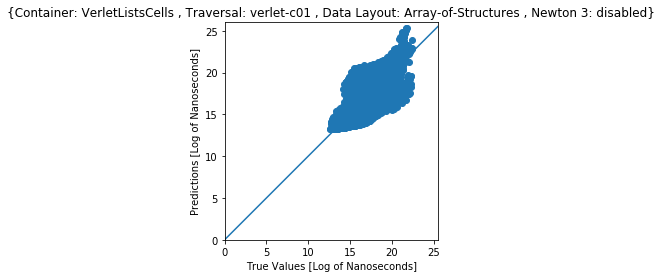

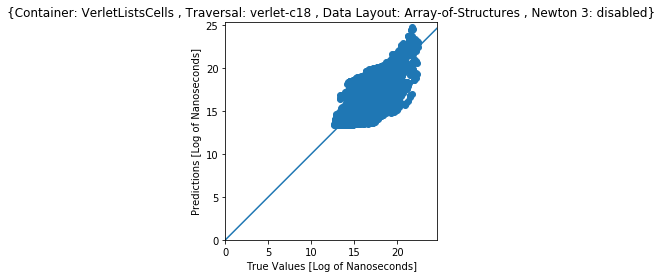

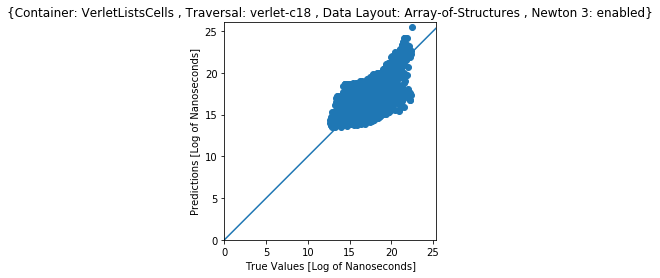

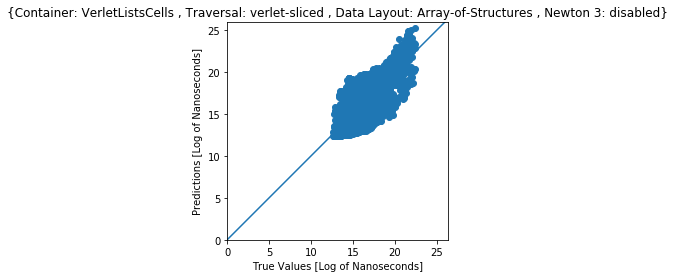

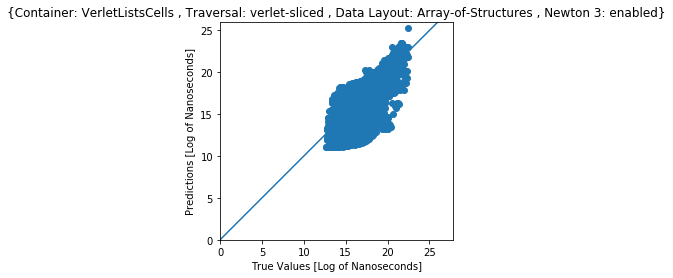

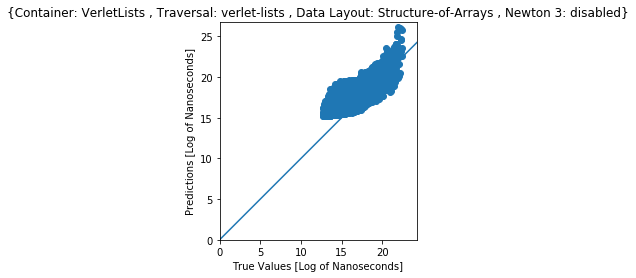

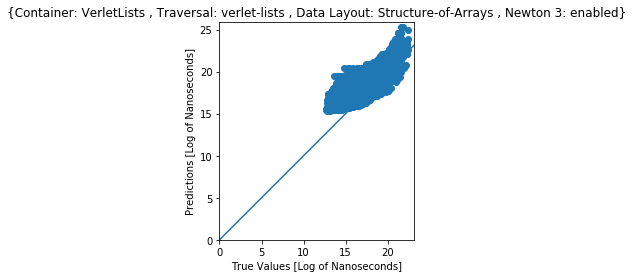

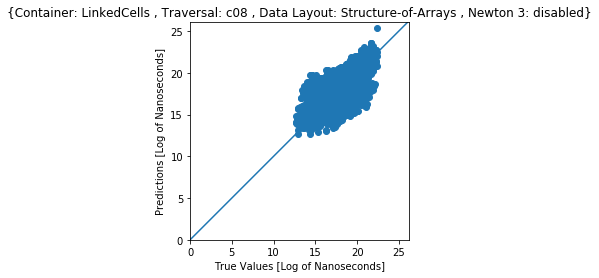

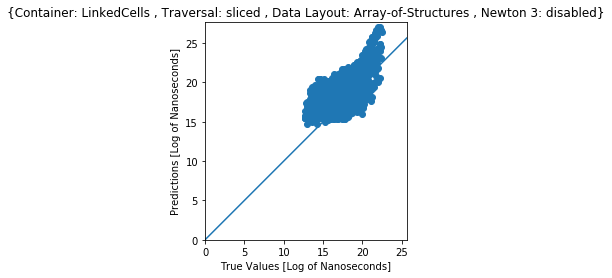

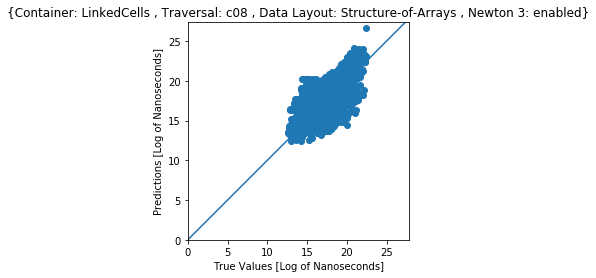

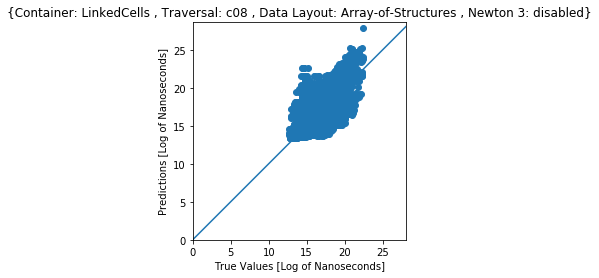

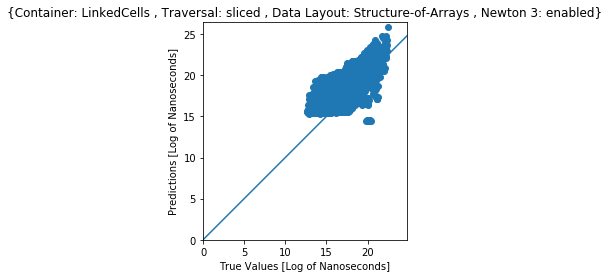

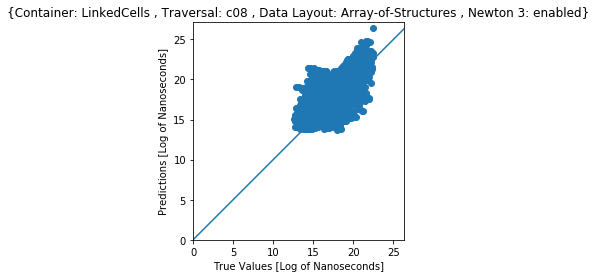

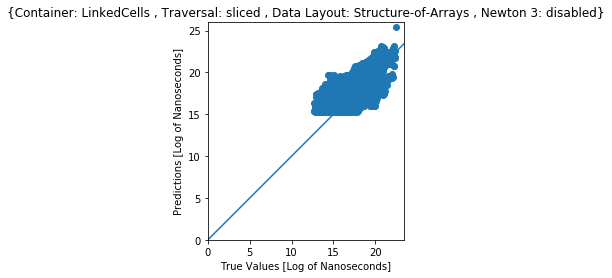

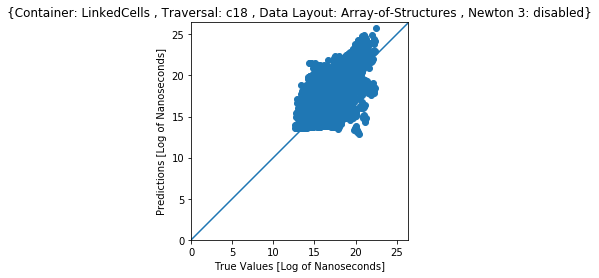

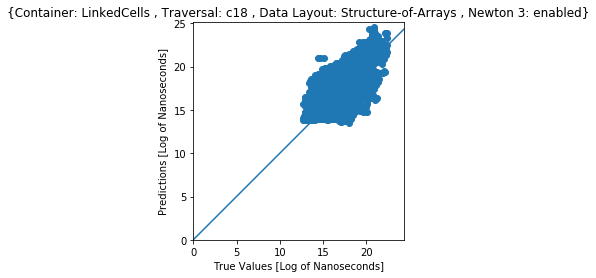

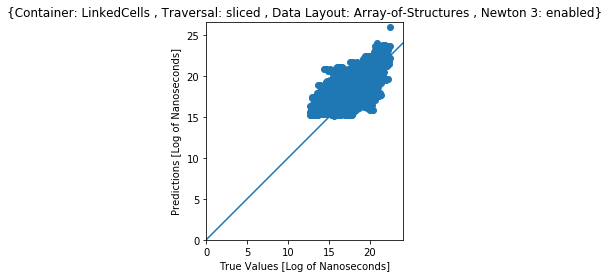

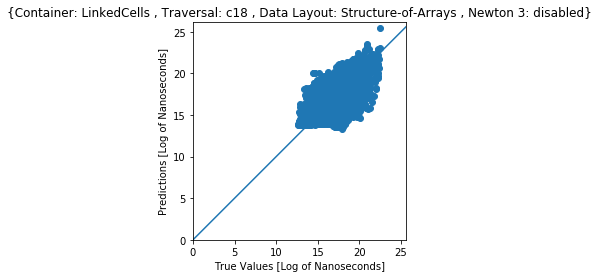

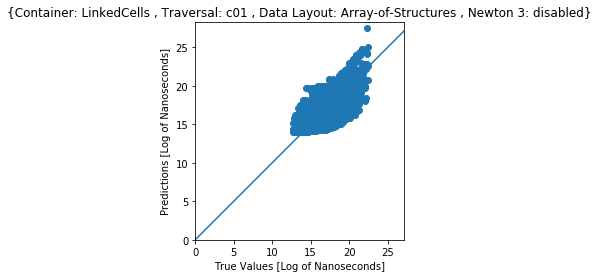

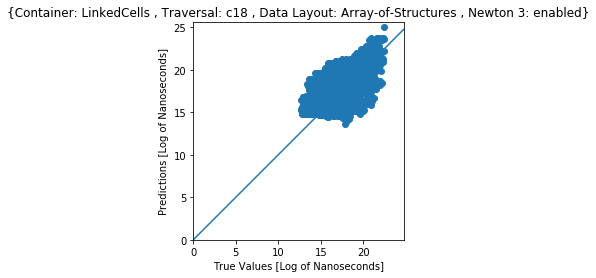

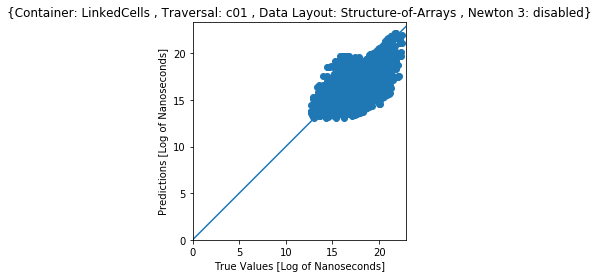

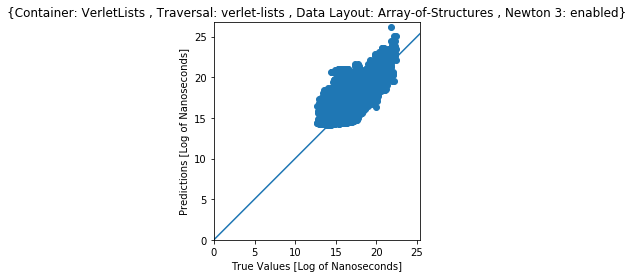

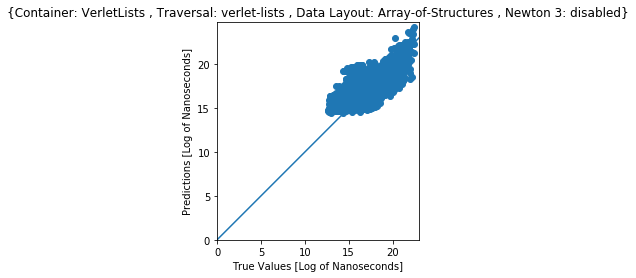

In [285]:
#reg_test_all_predictions[0] = model2.predict(reg_test_params).flatten()
for container in range(parameter_count, arr.shape[1]):
    plt.figure(container)
    plt.title(all_containers[container - parameter_count])
    plt.scatter(reg_test_labels, reg_test_all_predictions[container - parameter_count])
    plt.xlabel('True Values [Log of Nanoseconds]')
    plt.ylabel('Predictions [Log of Nanoseconds]')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,plt.xlim()[1]])
    plt.ylim([0,plt.ylim()[1]])
    _ = plt.plot([-100, 100], [-100, 100])

In [275]:
reg_best_predictions = np.argmin(reg_test_all_predictions, 0)
count = 0
for i in range(reg_test_size):
    if reg_best_predictions[i] == reg_test_best_labels[i]:
        count = count + 1
print(count/reg_test_size)

0.4411006018916595


In [276]:
reg_test_all_labels = reg_data[:reg_test_size,parameter_count:]
reg_test_all_labels = np.log(reg_test_all_labels)
reg_test_best_labels = np.argmin(reg_data[:reg_test_size,parameter_count:], 1).astype(int)

In [277]:
# Take the transpose of the predictions matrix (Because we trained the models on their own but now we want a grouping by experiment)
reg_test_all_predictions_transposed = np.transpose(reg_test_all_predictions)

In [278]:
# Print prediction, result, and how certain the result is
reg_best = np.argsort(reg_test_all_predictions_transposed, 1)
print(reg_best)
print(' Best  Guess1  Guess2   ValueB  ValueA1 ValueG1 ValueA2 ValueG2')
for i in range(reg_test_size):
    print(' ', reg_test_best_labels[i], '\t', reg_best[i][0], '\t', reg_best[i][1], '\t', \
          "{:.4}".format(reg_test_all_labels[i][reg_test_best_labels[i]]), '\t', \
          "{:.4}".format(reg_test_all_labels[i][reg_best[i][0]]), '\t', \
          "{:.4}".format(reg_test_all_predictions_transposed[i][reg_best[i][0]]), '\t', \
          "{:.4}".format(reg_test_all_labels[i][reg_best[i][1]]), '\t', \
          "{:.4}".format(reg_test_all_predictions_transposed[i][reg_best[i][1]]))

[[20  0 22 ...  8 14 10]
 [17 20 18 ...  3 21  6]
 [ 4  3  9 ...  8 16 11]
 ...
 [ 2 20  4 ... 11  5  6]
 [20 18  4 ...  8 14 12]
 [ 7 13 15 ... 14 10  8]]
 Best  Guess1  Guess2   ValueB  ValueA1 ValueG1 ValueA2 ValueG2
  0 	 20 	 0 	 18.15 	 18.74 	 18.96 	 18.15 	 19.48
  20 	 17 	 20 	 17.94 	 19.69 	 15.89 	 17.94 	 16.05
  20 	 4 	 3 	 12.4 	 13.04 	 12.37 	 13.69 	 12.75
  22 	 20 	 7 	 14.67 	 14.94 	 13.42 	 15.71 	 14.08
  20 	 20 	 0 	 18.62 	 18.62 	 16.13 	 19.21 	 16.47
  22 	 2 	 20 	 15.3 	 16.23 	 17.11 	 15.32 	 17.34
  0 	 20 	 22 	 16.04 	 16.54 	 16.87 	 16.95 	 17.36
  20 	 0 	 2 	 19.35 	 19.76 	 16.73 	 21.33 	 17.43
  0 	 4 	 3 	 13.55 	 13.83 	 11.15 	 14.51 	 12.56
  20 	 20 	 7 	 14.52 	 14.52 	 15.32 	 15.42 	 15.87
  7 	 4 	 1 	 15.36 	 16.34 	 13.7 	 15.59 	 15.33
  20 	 20 	 0 	 18.28 	 18.28 	 17.04 	 18.66 	 17.34
  0 	 20 	 12 	 13.53 	 13.75 	 14.38 	 13.64 	 14.8
  20 	 4 	 20 	 16.9 	 18.7 	 13.5 	 16.9 	 13.89
  0 	 20 	 7 	 17.14 	 17.46 	 14.54 	

  0 	 20 	 22 	 16.25 	 16.97 	 17.43 	 17.11 	 17.47
  0 	 20 	 0 	 15.9 	 15.97 	 16.41 	 15.9 	 16.91
  4 	 4 	 3 	 11.65 	 11.65 	 12.2 	 12.06 	 12.57
  20 	 4 	 3 	 13.95 	 15.63 	 11.66 	 16.29 	 13.54
  2 	 20 	 17 	 15.4 	 15.75 	 15.44 	 16.04 	 15.53
  7 	 4 	 9 	 14.49 	 14.69 	 12.89 	 14.68 	 14.62
  0 	 0 	 20 	 17.69 	 17.69 	 17.31 	 17.77 	 17.37
  20 	 20 	 0 	 13.54 	 13.54 	 14.3 	 14.18 	 14.7
  4 	 4 	 1 	 13.62 	 13.62 	 12.89 	 15.11 	 14.52
  20 	 22 	 20 	 16.7 	 17.07 	 18.12 	 16.7 	 18.19
  0 	 20 	 0 	 18.33 	 18.4 	 18.03 	 18.33 	 18.25
  20 	 0 	 20 	 15.14 	 15.33 	 16.25 	 15.14 	 16.84
  20 	 20 	 4 	 13.86 	 13.86 	 14.07 	 15.03 	 14.49
  0 	 20 	 22 	 15.24 	 16.07 	 16.4 	 15.85 	 16.49
  20 	 22 	 20 	 16.19 	 17.29 	 18.12 	 16.19 	 18.19
  0 	 20 	 0 	 14.93 	 15.22 	 16.35 	 14.93 	 16.64
  20 	 2 	 0 	 15.08 	 17.21 	 14.75 	 15.71 	 14.84
  20 	 0 	 20 	 19.78 	 20.76 	 18.06 	 19.78 	 18.47
  20 	 20 	 0 	 13.29 	 13.29 	 14.52 	 14.12 	 

  20 	 4 	 9 	 17.22 	 19.7 	 13.74 	 19.02 	 14.86
  4 	 17 	 4 	 14.66 	 15.06 	 13.61 	 14.66 	 13.72
  12 	 4 	 9 	 14.99 	 15.86 	 13.38 	 15.32 	 14.2
  20 	 4 	 1 	 17.76 	 20.21 	 13.82 	 20.33 	 15.43
  0 	 20 	 0 	 17.45 	 17.65 	 17.72 	 17.45 	 17.82
  20 	 20 	 0 	 18.04 	 18.04 	 18.23 	 18.93 	 18.74
  20 	 20 	 4 	 13.04 	 13.04 	 13.7 	 14.28 	 13.83
  20 	 20 	 18 	 19.34 	 19.34 	 18.37 	 20.7 	 19.73
  20 	 20 	 18 	 15.51 	 15.51 	 17.13 	 16.99 	 18.29
  2 	 20 	 2 	 16.77 	 17.4 	 16.83 	 16.77 	 16.93
  20 	 0 	 20 	 15.18 	 15.45 	 16.1 	 15.18 	 16.16
  13 	 9 	 11 	 20.3 	 20.38 	 20.22 	 20.31 	 20.42
  1 	 2 	 20 	 16.99 	 17.48 	 16.63 	 17.14 	 16.78
  4 	 4 	 1 	 14.57 	 14.57 	 14.16 	 15.34 	 15.14
  0 	 20 	 0 	 19.2 	 19.48 	 19.9 	 19.2 	 20.05
  0 	 20 	 18 	 19.25 	 19.95 	 17.99 	 20.99 	 19.36
  20 	 0 	 20 	 18.11 	 18.7 	 18.17 	 18.11 	 18.35
  2 	 2 	 14 	 19.59 	 19.59 	 17.32 	 21.14 	 18.46
  4 	 4 	 3 	 11.87 	 11.87 	 12.28 	 12.58 	 12

  20 	 20 	 18 	 14.25 	 14.25 	 15.15 	 15.4 	 15.18
  4 	 4 	 3 	 12.6 	 12.6 	 12.43 	 13.15 	 12.93
  0 	 20 	 0 	 18.1 	 18.86 	 18.82 	 18.1 	 19.51
  20 	 4 	 20 	 14.81 	 16.64 	 16.27 	 14.81 	 16.44
  0 	 4 	 20 	 12.77 	 13.41 	 13.14 	 12.96 	 13.74
  2 	 4 	 3 	 13.61 	 14.21 	 12.85 	 15.57 	 13.53
  0 	 20 	 22 	 20.0 	 20.18 	 18.84 	 20.5 	 20.9
  13 	 11 	 9 	 20.91 	 20.91 	 20.93 	 20.99 	 20.98
  2 	 4 	 9 	 12.84 	 13.09 	 13.16 	 13.61 	 13.8
  0 	 2 	 20 	 14.05 	 14.79 	 15.04 	 14.45 	 15.2
  20 	 20 	 2 	 16.2 	 16.2 	 14.42 	 17.9 	 15.01
  0 	 20 	 0 	 16.25 	 16.85 	 17.21 	 16.25 	 17.41
  0 	 20 	 0 	 13.09 	 13.63 	 14.11 	 13.09 	 14.89
  2 	 20 	 17 	 15.86 	 16.09 	 15.57 	 16.25 	 15.66
  20 	 2 	 4 	 13.75 	 13.85 	 14.35 	 14.4 	 14.69
  4 	 4 	 3 	 11.75 	 11.75 	 11.29 	 12.39 	 13.14
  9 	 13 	 7 	 18.58 	 18.61 	 18.88 	 18.59 	 18.89
  22 	 22 	 20 	 14.48 	 14.48 	 16.67 	 14.85 	 16.68
  20 	 20 	 22 	 16.99 	 16.99 	 17.24 	 17.95 	 17.59


  4 	 4 	 3 	 11.83 	 11.83 	 11.28 	 12.6 	 12.66
  22 	 2 	 17 	 14.61 	 15.55 	 16.81 	 15.37 	 17.13
  20 	 0 	 20 	 18.21 	 18.21 	 18.46 	 18.21 	 18.63
  22 	 2 	 4 	 15.71 	 16.68 	 17.17 	 16.64 	 17.54
  4 	 4 	 3 	 14.99 	 14.99 	 13.41 	 15.66 	 14.74
  20 	 4 	 3 	 12.29 	 13.09 	 11.74 	 13.65 	 13.03
  0 	 20 	 0 	 17.87 	 18.45 	 18.27 	 17.87 	 18.39
  13 	 9 	 11 	 21.32 	 21.37 	 21.18 	 21.32 	 21.19
  4 	 4 	 14 	 14.18 	 14.18 	 12.91 	 15.33 	 14.08
  0 	 20 	 0 	 17.73 	 18.14 	 17.81 	 17.73 	 18.07
  20 	 4 	 20 	 17.12 	 19.16 	 13.58 	 17.12 	 14.1
  4 	 4 	 3 	 12.56 	 12.56 	 11.44 	 13.37 	 13.31
  20 	 0 	 2 	 14.96 	 15.28 	 15.88 	 15.14 	 16.26
  2 	 0 	 2 	 16.74 	 17.04 	 16.42 	 16.74 	 16.47
  20 	 18 	 2 	 18.63 	 19.88 	 19.47 	 20.89 	 19.54
  4 	 4 	 9 	 15.22 	 15.22 	 13.2 	 15.45 	 14.35
  20 	 17 	 18 	 18.63 	 20.79 	 19.36 	 19.88 	 19.38
  0 	 20 	 0 	 17.64 	 17.67 	 17.08 	 17.64 	 17.82
  20 	 4 	 20 	 11.92 	 12.05 	 12.72 	 11.92 	

  7 	 4 	 1 	 15.83 	 15.9 	 14.47 	 15.95 	 15.18
  11 	 9 	 11 	 20.3 	 20.43 	 20.22 	 20.3 	 20.42
  4 	 4 	 14 	 13.74 	 13.74 	 12.93 	 15.55 	 14.27
  4 	 4 	 1 	 12.13 	 12.13 	 11.67 	 14.09 	 13.62
  0 	 0 	 20 	 16.89 	 16.89 	 18.07 	 17.74 	 18.1
  4 	 4 	 20 	 11.63 	 11.63 	 13.18 	 12.44 	 13.7
  4 	 4 	 3 	 12.59 	 12.59 	 12.5 	 13.21 	 14.02
  20 	 0 	 20 	 18.42 	 18.88 	 18.27 	 18.42 	 18.64
  20 	 20 	 0 	 15.68 	 15.68 	 15.89 	 15.88 	 16.51
  0 	 20 	 22 	 15.85 	 16.19 	 16.97 	 16.73 	 17.27
  1 	 4 	 3 	 14.0 	 14.3 	 12.63 	 15.51 	 14.13
  2 	 20 	 7 	 15.43 	 15.55 	 15.01 	 15.73 	 15.07
  0 	 20 	 22 	 15.69 	 16.28 	 16.58 	 16.78 	 16.58
  4 	 4 	 3 	 10.62 	 10.62 	 12.06 	 11.25 	 12.48
  0 	 20 	 22 	 19.4 	 19.53 	 19.26 	 19.84 	 20.5
  20 	 20 	 0 	 15.95 	 15.95 	 16.93 	 16.23 	 16.95
  4 	 4 	 1 	 14.33 	 14.33 	 13.49 	 15.26 	 15.3
  20 	 0 	 20 	 17.42 	 17.76 	 18.1 	 17.42 	 18.39
  20 	 0 	 20 	 17.37 	 17.49 	 17.45 	 17.37 	 17.94
  

  0 	 20 	 22 	 16.08 	 16.32 	 16.51 	 17.55 	 17.06
  2 	 4 	 2 	 15.61 	 16.93 	 15.37 	 15.61 	 15.98
  0 	 20 	 22 	 17.57 	 17.71 	 18.16 	 18.51 	 18.43
  7 	 4 	 9 	 14.25 	 15.39 	 12.5 	 14.62 	 13.95
  2 	 4 	 3 	 13.94 	 14.63 	 12.42 	 15.24 	 13.81
  0 	 20 	 0 	 17.73 	 17.89 	 17.36 	 17.73 	 17.78
  20 	 20 	 22 	 18.76 	 18.76 	 18.77 	 19.84 	 19.96
  20 	 20 	 0 	 15.15 	 15.15 	 15.94 	 15.55 	 16.01
  20 	 2 	 20 	 15.91 	 17.4 	 14.85 	 15.91 	 15.07
  20 	 20 	 22 	 19.31 	 19.31 	 19.11 	 20.64 	 20.46
  2 	 4 	 20 	 15.15 	 16.34 	 14.84 	 15.25 	 15.28
  2 	 2 	 1 	 16.55 	 16.55 	 16.2 	 17.0 	 16.38
  2 	 4 	 14 	 15.34 	 16.24 	 14.17 	 16.42 	 14.95
  20 	 20 	 0 	 17.02 	 17.02 	 17.23 	 18.08 	 18.11
  4 	 4 	 3 	 13.33 	 13.33 	 12.97 	 13.99 	 13.68
  2 	 4 	 3 	 13.55 	 14.25 	 12.35 	 14.92 	 13.68
  0 	 20 	 0 	 17.76 	 18.36 	 18.87 	 17.76 	 18.94
  0 	 20 	 22 	 15.36 	 16.57 	 17.08 	 16.2 	 17.2
  20 	 0 	 20 	 14.74 	 16.84 	 17.11 	 14.74 	 

  20 	 4 	 20 	 12.54 	 13.77 	 13.14 	 12.54 	 13.36
  4 	 4 	 3 	 10.52 	 10.52 	 12.02 	 11.03 	 12.5
  0 	 20 	 18 	 17.64 	 18.25 	 18.01 	 19.16 	 18.27
  20 	 0 	 20 	 16.82 	 17.23 	 17.61 	 16.82 	 17.86
  1 	 4 	 3 	 13.73 	 13.76 	 13.73 	 14.29 	 14.54
  0 	 0 	 1 	 13.45 	 13.45 	 15.3 	 14.1 	 15.41
  20 	 20 	 18 	 19.66 	 19.66 	 19.34 	 21.23 	 20.83
  13 	 2 	 4 	 15.76 	 16.39 	 17.07 	 16.34 	 17.36
  20 	 4 	 3 	 14.5 	 16.03 	 12.74 	 16.46 	 13.39
  20 	 0 	 1 	 16.2 	 16.4 	 16.74 	 17.03 	 17.32
  11 	 7 	 13 	 19.14 	 19.26 	 18.71 	 19.15 	 19.29
  2 	 2 	 20 	 16.55 	 16.55 	 16.76 	 17.14 	 16.77
  20 	 20 	 0 	 18.45 	 18.45 	 16.9 	 19.24 	 17.32
  0 	 0 	 20 	 17.15 	 17.15 	 18.29 	 17.53 	 18.93
  20 	 20 	 0 	 13.33 	 13.33 	 14.54 	 13.56 	 15.22
  20 	 20 	 0 	 16.06 	 16.06 	 16.3 	 16.26 	 16.42
  0 	 0 	 20 	 17.68 	 17.68 	 18.52 	 18.26 	 18.73
  20 	 20 	 22 	 17.33 	 17.33 	 17.68 	 18.57 	 18.55
  0 	 20 	 0 	 14.2 	 14.74 	 15.98 	 14.2 	 1

  4 	 4 	 3 	 12.67 	 12.67 	 11.51 	 13.47 	 13.41
  2 	 20 	 0 	 14.66 	 14.94 	 15.64 	 15.48 	 15.78
  0 	 20 	 0 	 17.71 	 18.24 	 18.24 	 17.71 	 19.1
  20 	 20 	 0 	 17.38 	 17.38 	 16.35 	 17.62 	 16.69
  20 	 20 	 0 	 16.36 	 16.36 	 15.79 	 16.57 	 16.97
  20 	 4 	 3 	 12.65 	 13.48 	 12.49 	 14.04 	 12.86
  20 	 4 	 20 	 12.87 	 13.83 	 13.51 	 12.87 	 13.75
  4 	 4 	 3 	 9.96 	 9.96 	 11.98 	 10.28 	 12.41
  11 	 2 	 4 	 16.19 	 17.93 	 17.66 	 17.02 	 17.91
  0 	 20 	 0 	 18.68 	 19.52 	 18.69 	 18.68 	 19.5
  2 	 4 	 0 	 14.44 	 15.6 	 15.23 	 15.1 	 15.39
  2 	 4 	 1 	 15.56 	 16.41 	 15.4 	 15.69 	 15.46
  20 	 20 	 2 	 20.63 	 20.63 	 20.1 	 22.41 	 20.97
  0 	 20 	 22 	 16.03 	 16.14 	 16.97 	 16.62 	 17.27
  20 	 20 	 22 	 15.24 	 15.24 	 16.54 	 15.68 	 16.98
  20 	 20 	 7 	 16.52 	 16.52 	 16.54 	 16.7 	 16.78
  20 	 0 	 20 	 14.98 	 15.15 	 16.35 	 14.98 	 17.05
  2 	 17 	 20 	 14.97 	 15.48 	 14.1 	 15.58 	 14.47
  20 	 20 	 12 	 13.61 	 13.61 	 14.32 	 14.77 	 1

  20 	 20 	 0 	 15.35 	 15.35 	 16.95 	 16.06 	 17.06
  0 	 20 	 0 	 16.13 	 16.2 	 17.18 	 16.13 	 17.28
  22 	 2 	 4 	 15.61 	 16.62 	 17.07 	 16.55 	 17.36
  20 	 4 	 3 	 13.4 	 14.58 	 11.46 	 15.18 	 12.86
  2 	 4 	 2 	 14.62 	 15.44 	 15.1 	 14.62 	 15.41
  20 	 4 	 3 	 14.71 	 16.36 	 13.62 	 16.74 	 13.9
  20 	 20 	 0 	 18.89 	 18.89 	 15.19 	 19.04 	 16.49
  20 	 4 	 20 	 17.75 	 20.25 	 15.03 	 17.75 	 15.65
  22 	 20 	 18 	 14.23 	 14.85 	 16.16 	 16.9 	 16.97
  2 	 20 	 2 	 15.31 	 15.91 	 15.41 	 15.31 	 15.44
  20 	 20 	 0 	 15.55 	 15.55 	 17.97 	 18.15 	 18.05
  22 	 13 	 9 	 17.3 	 17.47 	 18.49 	 17.34 	 18.63
  20 	 20 	 0 	 14.17 	 14.17 	 14.61 	 14.6 	 14.85
  4 	 4 	 3 	 12.35 	 12.35 	 12.32 	 13.01 	 12.94
  20 	 4 	 3 	 14.85 	 16.77 	 12.15 	 17.21 	 13.62
  0 	 20 	 0 	 16.94 	 17.01 	 17.08 	 16.94 	 17.81
  0 	 20 	 22 	 17.0 	 17.97 	 17.93 	 18.83 	 18.19
  20 	 0 	 20 	 14.72 	 15.27 	 14.84 	 14.72 	 15.13
  20 	 20 	 0 	 18.41 	 18.41 	 18.18 	 18.57 

  4 	 4 	 1 	 14.18 	 14.18 	 13.63 	 14.77 	 14.66
  0 	 0 	 20 	 16.23 	 16.23 	 17.75 	 17.36 	 17.78
  20 	 20 	 19 	 17.6 	 17.6 	 16.87 	 19.84 	 17.28
  20 	 0 	 20 	 18.45 	 19.1 	 16.4 	 18.45 	 16.8
  4 	 4 	 9 	 12.46 	 12.46 	 11.79 	 14.27 	 13.66
  2 	 20 	 0 	 16.33 	 16.55 	 16.61 	 16.57 	 16.79
  2 	 20 	 1 	 16.99 	 17.5 	 16.87 	 17.53 	 16.89
  20 	 0 	 20 	 14.91 	 15.57 	 15.05 	 14.91 	 15.57
  0 	 20 	 0 	 17.69 	 18.11 	 17.78 	 17.69 	 18.07
  0 	 20 	 0 	 14.49 	 14.53 	 15.69 	 14.49 	 15.9
  2 	 4 	 9 	 13.12 	 13.47 	 13.85 	 14.05 	 14.77
  20 	 20 	 19 	 21.48 	 21.48 	 17.46 	 23.3 	 19.87
  2 	 20 	 17 	 15.52 	 15.74 	 15.34 	 16.04 	 15.41
  4 	 4 	 3 	 10.76 	 10.76 	 12.04 	 11.4 	 12.5
  11 	 7 	 9 	 19.65 	 19.75 	 19.32 	 19.7 	 19.71
  0 	 0 	 20 	 18.01 	 18.01 	 18.58 	 18.56 	 19.39
  0 	 20 	 0 	 18.26 	 18.64 	 18.38 	 18.26 	 18.63
  20 	 0 	 19 	 13.54 	 13.55 	 15.31 	 17.41 	 16.12
  0 	 20 	 0 	 12.83 	 13.05 	 14.54 	 12.83 	 15.17


  0 	 20 	 0 	 17.54 	 17.99 	 17.73 	 17.54 	 18.29
  20 	 20 	 0 	 15.24 	 15.24 	 15.43 	 15.58 	 16.24
  20 	 0 	 20 	 19.99 	 20.97 	 18.07 	 19.99 	 18.1
  0 	 20 	 0 	 13.63 	 13.83 	 15.15 	 13.63 	 15.39
  2 	 4 	 20 	 13.28 	 14.19 	 13.71 	 13.91 	 13.91
  0 	 20 	 0 	 18.78 	 19.3 	 18.5 	 18.78 	 19.08
  20 	 20 	 0 	 18.13 	 18.13 	 17.78 	 18.23 	 18.29
  20 	 20 	 22 	 17.15 	 17.15 	 17.37 	 18.2 	 18.25
  20 	 20 	 0 	 14.71 	 14.71 	 15.43 	 14.74 	 15.73
  17 	 13 	 7 	 18.29 	 18.34 	 18.67 	 18.33 	 18.77
  11 	 7 	 11 	 19.64 	 19.87 	 19.03 	 19.64 	 19.73
  7 	 4 	 14 	 15.64 	 15.87 	 13.57 	 16.24 	 15.5
  0 	 20 	 0 	 15.92 	 15.94 	 16.26 	 15.92 	 16.67
  20 	 20 	 0 	 16.2 	 16.2 	 14.77 	 16.58 	 15.38
  4 	 4 	 1 	 15.11 	 15.11 	 13.26 	 15.71 	 15.19
  4 	 0 	 1 	 11.63 	 11.97 	 14.58 	 12.33 	 14.66
  2 	 12 	 20 	 16.52 	 16.82 	 15.32 	 16.62 	 15.47
  13 	 2 	 1 	 16.58 	 17.18 	 17.98 	 18.13 	 18.32
  20 	 20 	 12 	 15.55 	 15.55 	 14.47 	 18.0

  7 	 4 	 9 	 15.09 	 15.31 	 13.23 	 15.27 	 14.47
  20 	 20 	 22 	 19.79 	 19.79 	 17.37 	 20.12 	 17.9
  0 	 0 	 2 	 16.78 	 16.78 	 17.92 	 18.13 	 18.79
  20 	 4 	 9 	 14.5 	 14.68 	 12.95 	 14.67 	 14.84
  4 	 4 	 14 	 13.63 	 13.63 	 13.0 	 15.44 	 14.5
  0 	 0 	 20 	 16.35 	 16.35 	 17.84 	 17.28 	 18.64
  2 	 0 	 20 	 17.45 	 17.47 	 17.53 	 17.85 	 17.69
  22 	 17 	 11 	 15.15 	 15.79 	 16.81 	 15.77 	 17.6
  0 	 4 	 3 	 11.6 	 11.91 	 13.68 	 12.45 	 13.84
  20 	 0 	 1 	 18.74 	 18.85 	 16.64 	 21.04 	 17.23
  20 	 20 	 18 	 18.1 	 18.1 	 17.44 	 19.43 	 18.19
  4 	 4 	 3 	 13.03 	 13.03 	 11.76 	 15.24 	 13.21
  20 	 22 	 20 	 17.12 	 18.42 	 17.66 	 17.12 	 18.06
  20 	 4 	 20 	 12.35 	 13.06 	 13.03 	 12.35 	 13.64
  11 	 9 	 11 	 20.91 	 20.94 	 20.96 	 20.91 	 20.97
  0 	 0 	 20 	 17.84 	 17.84 	 18.07 	 18.26 	 18.2
  20 	 4 	 3 	 13.24 	 13.89 	 12.22 	 14.52 	 12.69
  2 	 0 	 2 	 17.46 	 17.62 	 17.32 	 17.46 	 17.38
  7 	 4 	 9 	 14.25 	 14.5 	 12.6 	 14.46 	 14.22


  0 	 7 	 0 	 16.83 	 17.67 	 17.08 	 16.83 	 17.13
  20 	 20 	 0 	 17.7 	 17.7 	 18.26 	 18.22 	 18.28
  20 	 2 	 20 	 17.94 	 19.35 	 15.93 	 17.94 	 16.1
  2 	 20 	 1 	 16.92 	 17.33 	 16.72 	 17.39 	 16.87
  2 	 2 	 20 	 16.47 	 16.47 	 15.95 	 16.63 	 16.08
  20 	 20 	 0 	 15.04 	 15.04 	 15.26 	 15.91 	 15.26
  20 	 4 	 20 	 14.7 	 16.18 	 12.98 	 14.7 	 13.69
  2 	 17 	 20 	 15.63 	 16.06 	 15.07 	 16.05 	 15.47
  4 	 4 	 1 	 14.57 	 14.57 	 13.31 	 15.48 	 15.28
  0 	 0 	 4 	 17.68 	 17.68 	 18.6 	 19.61 	 19.1
  20 	 0 	 20 	 14.73 	 15.56 	 17.11 	 14.73 	 17.56
  20 	 20 	 0 	 13.7 	 13.7 	 14.64 	 15.21 	 15.06
  20 	 2 	 17 	 16.25 	 17.4 	 15.61 	 16.49 	 15.64
  1 	 4 	 20 	 14.27 	 15.0 	 13.02 	 14.6 	 14.36
  0 	 2 	 20 	 17.29 	 17.61 	 16.33 	 17.33 	 16.64
  2 	 4 	 20 	 13.8 	 14.85 	 12.81 	 14.46 	 14.16
  20 	 4 	 3 	 12.67 	 13.71 	 11.57 	 14.37 	 12.9
  2 	 2 	 17 	 16.46 	 16.46 	 16.03 	 17.12 	 16.54
  22 	 2 	 4 	 14.85 	 15.96 	 17.0 	 15.85 	 17.7
  20

  2 	 4 	 9 	 13.13 	 13.92 	 13.51 	 14.17 	 13.91
  4 	 4 	 3 	 12.17 	 12.17 	 12.22 	 12.89 	 12.69
  2 	 2 	 20 	 13.08 	 13.08 	 13.91 	 13.09 	 14.26
  20 	 0 	 1 	 16.18 	 16.3 	 17.03 	 17.93 	 18.26
  7 	 4 	 7 	 14.92 	 15.06 	 13.79 	 14.92 	 14.53
  20 	 20 	 18 	 19.84 	 19.84 	 19.42 	 21.36 	 20.92
  0 	 4 	 3 	 12.75 	 13.22 	 11.11 	 13.96 	 12.9
  20 	 20 	 0 	 16.2 	 16.2 	 16.44 	 16.49 	 17.48
  4 	 4 	 3 	 11.31 	 11.31 	 13.43 	 11.84 	 13.66
  4 	 4 	 3 	 13.29 	 13.29 	 12.39 	 13.96 	 13.9
  20 	 2 	 20 	 13.34 	 15.12 	 14.34 	 13.34 	 14.43
  7 	 1 	 4 	 16.61 	 16.81 	 15.74 	 17.73 	 16.06
  0 	 0 	 22 	 16.43 	 16.43 	 17.49 	 18.27 	 18.07
  20 	 20 	 0 	 17.78 	 17.78 	 16.81 	 18.12 	 16.84
  2 	 1 	 2 	 15.7 	 16.11 	 15.64 	 15.7 	 15.76
  2 	 2 	 1 	 16.49 	 16.49 	 16.29 	 16.95 	 16.56
  0 	 0 	 20 	 16.09 	 16.09 	 17.61 	 16.56 	 17.86
  20 	 20 	 22 	 15.19 	 15.19 	 16.54 	 16.48 	 16.98
  0 	 0 	 4 	 17.54 	 17.54 	 18.6 	 19.25 	 19.1
  4 	

  20 	 20 	 0 	 17.69 	 17.69 	 17.23 	 17.9 	 17.86
  20 	 0 	 20 	 17.19 	 17.26 	 16.1 	 17.19 	 16.16
  20 	 20 	 4 	 14.15 	 14.15 	 14.14 	 15.44 	 14.16
  4 	 4 	 3 	 13.65 	 13.65 	 12.91 	 14.3 	 14.67
  4 	 4 	 3 	 11.38 	 11.38 	 11.19 	 12.1 	 12.6
  20 	 0 	 1 	 15.89 	 15.96 	 16.57 	 16.56 	 17.46
  7 	 4 	 20 	 13.7 	 14.05 	 13.43 	 13.84 	 13.73
  20 	 20 	 18 	 18.22 	 18.22 	 18.26 	 19.61 	 19.55
  4 	 4 	 3 	 11.86 	 11.86 	 11.31 	 12.63 	 12.73
  20 	 2 	 0 	 13.6 	 16.36 	 14.9 	 13.8 	 15.04
  4 	 4 	 3 	 11.42 	 11.42 	 11.17 	 12.22 	 12.98
  4 	 4 	 3 	 13.71 	 13.71 	 12.37 	 14.49 	 13.83
  20 	 20 	 18 	 18.09 	 18.09 	 17.44 	 19.37 	 18.19
  20 	 7 	 12 	 15.74 	 15.8 	 15.27 	 15.9 	 15.3
  0 	 20 	 18 	 19.34 	 19.81 	 18.74 	 20.84 	 19.27
  11 	 7 	 9 	 19.87 	 19.91 	 19.39 	 20.06 	 19.87
  22 	 20 	 4 	 15.13 	 15.77 	 17.62 	 16.07 	 17.71
  20 	 20 	 2 	 13.94 	 13.94 	 13.92 	 14.81 	 14.22
  4 	 4 	 3 	 12.81 	 12.81 	 11.97 	 13.5 	 13.47
 

  4 	 4 	 3 	 12.75 	 12.75 	 11.81 	 13.48 	 13.25
  20 	 0 	 2 	 15.9 	 16.18 	 15.19 	 17.59 	 15.19
  4 	 4 	 3 	 11.61 	 11.61 	 12.12 	 12.11 	 12.69
  20 	 0 	 1 	 16.19 	 16.42 	 16.74 	 17.25 	 17.32
  11 	 7 	 13 	 19.14 	 19.43 	 19.04 	 19.14 	 19.33
  0 	 2 	 1 	 17.33 	 17.52 	 16.61 	 17.71 	 16.78
  20 	 20 	 22 	 18.33 	 18.33 	 16.66 	 18.96 	 17.13
  20 	 4 	 20 	 14.83 	 16.31 	 15.14 	 14.83 	 15.15
  20 	 20 	 0 	 18.28 	 18.28 	 17.04 	 18.43 	 17.34
  0 	 20 	 22 	 15.48 	 15.76 	 15.97 	 17.07 	 16.97
  0 	 20 	 0 	 18.19 	 18.57 	 18.68 	 18.19 	 19.41
  0 	 20 	 0 	 18.24 	 18.43 	 18.84 	 18.24 	 19.05
  4 	 4 	 3 	 12.63 	 12.63 	 13.04 	 13.31 	 13.86
  12 	 4 	 14 	 15.59 	 16.15 	 13.79 	 16.17 	 15.42
  20 	 4 	 3 	 12.19 	 12.51 	 12.78 	 13.05 	 13.07
  20 	 20 	 22 	 17.64 	 17.64 	 17.91 	 18.94 	 18.58
  0 	 20 	 0 	 18.38 	 19.23 	 18.81 	 18.38 	 19.4
  4 	 4 	 3 	 12.74 	 12.74 	 13.31 	 13.43 	 14.06
  20 	 4 	 3 	 15.2 	 17.13 	 12.46 	 17.66 

  2 	 4 	 9 	 15.16 	 15.89 	 13.4 	 15.5 	 14.34
  4 	 4 	 1 	 15.51 	 15.51 	 13.92 	 15.54 	 15.07
  20 	 20 	 0 	 16.11 	 16.11 	 16.6 	 16.31 	 16.74
  4 	 4 	 3 	 12.8 	 12.8 	 12.47 	 13.45 	 13.03
  20 	 20 	 0 	 14.76 	 14.76 	 14.6 	 14.84 	 15.24
  20 	 20 	 2 	 12.79 	 12.79 	 14.03 	 13.89 	 14.49
  20 	 4 	 3 	 16.23 	 18.14 	 13.25 	 18.59 	 14.11
  0 	 0 	 20 	 16.9 	 16.9 	 17.82 	 17.25 	 17.87
  4 	 4 	 3 	 11.06 	 11.06 	 11.17 	 11.69 	 12.58
  0 	 0 	 20 	 17.15 	 17.15 	 18.29 	 17.54 	 18.93
  20 	 20 	 2 	 14.49 	 14.49 	 14.89 	 15.73 	 15.07
  20 	 4 	 20 	 17.37 	 19.38 	 13.71 	 17.37 	 14.39
  2 	 4 	 20 	 13.07 	 13.85 	 13.81 	 13.48 	 13.9
  20 	 17 	 0 	 16.75 	 16.99 	 16.56 	 17.0 	 16.79
  20 	 4 	 9 	 16.91 	 18.47 	 13.67 	 19.02 	 14.19
  4 	 4 	 15 	 13.98 	 13.98 	 13.03 	 15.6 	 14.66
  20 	 20 	 0 	 15.37 	 15.37 	 15.74 	 15.64 	 16.24
  20 	 20 	 18 	 17.09 	 17.09 	 16.62 	 18.67 	 17.15
  22 	 20 	 18 	 14.5 	 14.85 	 17.01 	 17.29 	 17.1

  20 	 20 	 0 	 18.72 	 18.72 	 16.96 	 19.26 	 17.43
  2 	 0 	 2 	 15.21 	 15.51 	 16.41 	 15.21 	 16.55
  20 	 0 	 2 	 17.9 	 18.07 	 18.05 	 18.47 	 19.44
  20 	 20 	 0 	 18.3 	 18.3 	 16.92 	 18.36 	 17.17
  0 	 0 	 20 	 18.26 	 18.26 	 18.97 	 19.13 	 19.6
  0 	 20 	 0 	 18.91 	 19.31 	 18.5 	 18.91 	 19.06
  11 	 11 	 9 	 20.91 	 20.91 	 20.93 	 20.98 	 20.98
  20 	 20 	 19 	 19.72 	 19.72 	 15.31 	 21.5 	 16.65
  0 	 20 	 2 	 14.05 	 14.2 	 14.47 	 14.96 	 15.11
  20 	 0 	 20 	 15.25 	 17.19 	 17.67 	 15.25 	 17.95
  1 	 2 	 1 	 17.15 	 17.53 	 16.47 	 17.15 	 16.64
  20 	 20 	 4 	 13.73 	 13.73 	 14.06 	 14.81 	 14.36
  20 	 20 	 2 	 14.37 	 14.37 	 14.26 	 17.19 	 15.04
  11 	 7 	 9 	 19.44 	 19.58 	 18.72 	 19.53 	 19.23
  4 	 4 	 3 	 13.9 	 13.9 	 12.95 	 14.46 	 14.5
  20 	 20 	 18 	 18.54 	 18.54 	 18.32 	 19.91 	 19.7
  20 	 4 	 9 	 13.47 	 15.02 	 12.46 	 15.72 	 13.52
  20 	 0 	 20 	 18.03 	 18.42 	 18.74 	 18.03 	 18.85
  0 	 20 	 0 	 16.02 	 16.05 	 16.52 	 16.02 	 16

  22 	 17 	 11 	 15.19 	 15.79 	 16.81 	 16.23 	 17.6
  20 	 2 	 20 	 14.37 	 15.89 	 14.24 	 14.37 	 14.44
  0 	 0 	 20 	 18.71 	 18.71 	 19.7 	 18.92 	 19.74
  20 	 22 	 18 	 16.21 	 17.59 	 16.15 	 17.81 	 16.33
  20 	 20 	 18 	 17.85 	 17.85 	 17.89 	 19.11 	 18.76
  0 	 20 	 17 	 17.48 	 17.72 	 13.71 	 18.56 	 14.76
  20 	 20 	 18 	 17.63 	 17.63 	 18.1 	 18.83 	 18.98
  2 	 1 	 17 	 16.04 	 16.47 	 15.97 	 16.68 	 16.13
  20 	 20 	 18 	 14.76 	 14.76 	 14.77 	 16.05 	 14.78
  20 	 0 	 1 	 12.79 	 13.02 	 14.87 	 14.5 	 15.5
  0 	 20 	 0 	 14.34 	 14.72 	 15.02 	 14.34 	 15.48
  20 	 20 	 0 	 17.68 	 17.68 	 18.63 	 18.31 	 19.27
  2 	 0 	 20 	 14.42 	 15.01 	 15.41 	 14.55 	 15.67
  2 	 4 	 20 	 12.97 	 13.42 	 13.29 	 13.4 	 13.68
  20 	 20 	 0 	 15.98 	 15.98 	 16.82 	 16.43 	 16.99
  7 	 4 	 14 	 14.93 	 15.3 	 13.32 	 15.59 	 14.62
  2 	 12 	 20 	 16.49 	 17.0 	 15.72 	 16.78 	 15.83
  22 	 13 	 7 	 16.98 	 17.32 	 18.47 	 17.33 	 18.7
  20 	 20 	 22 	 17.09 	 17.09 	 17.55 

  20 	 20 	 18 	 14.12 	 14.12 	 14.77 	 15.14 	 14.78
  20 	 20 	 0 	 16.03 	 16.03 	 17.2 	 16.93 	 18.07
  2 	 1 	 2 	 16.73 	 17.25 	 16.36 	 16.73 	 16.46
  20 	 20 	 2 	 12.49 	 12.49 	 14.16 	 14.09 	 14.32
  0 	 0 	 20 	 13.51 	 13.51 	 15.15 	 13.55 	 16.1
  4 	 4 	 3 	 10.75 	 10.75 	 11.09 	 11.31 	 12.89
  22 	 9 	 7 	 20.04 	 20.13 	 20.01 	 20.16 	 20.1
  20 	 20 	 4 	 13.38 	 13.38 	 13.89 	 14.81 	 14.04
  20 	 4 	 3 	 16.24 	 18.31 	 13.07 	 18.86 	 14.77
  4 	 4 	 9 	 13.19 	 13.19 	 12.86 	 15.79 	 13.84
  4 	 4 	 9 	 13.15 	 13.15 	 11.9 	 14.12 	 13.7
  20 	 4 	 9 	 15.37 	 17.56 	 12.32 	 17.05 	 13.86
  20 	 20 	 22 	 19.22 	 19.22 	 17.99 	 19.72 	 18.54
  0 	 20 	 0 	 15.87 	 15.97 	 17.05 	 15.87 	 17.1
  0 	 20 	 0 	 15.44 	 15.96 	 17.98 	 15.44 	 18.3
  20 	 4 	 9 	 17.36 	 19.81 	 13.27 	 19.17 	 14.51
  7 	 4 	 3 	 13.56 	 14.36 	 13.12 	 14.87 	 13.49
  20 	 4 	 3 	 14.31 	 15.44 	 11.46 	 16.0 	 12.91
  4 	 4 	 3 	 10.03 	 10.03 	 12.0 	 10.57 	 12.41
 

  0 	 7 	 20 	 16.35 	 16.61 	 15.9 	 16.38 	 15.99
  0 	 0 	 20 	 18.14 	 18.14 	 18.67 	 18.71 	 19.44
  1 	 4 	 17 	 14.06 	 14.23 	 13.44 	 14.53 	 13.63
  0 	 20 	 0 	 17.66 	 18.14 	 18.15 	 17.66 	 18.59
  20 	 20 	 18 	 17.91 	 17.91 	 16.36 	 19.38 	 16.97
  0 	 0 	 20 	 17.11 	 17.11 	 18.12 	 17.17 	 18.61
  0 	 22 	 19 	 16.28 	 17.24 	 16.62 	 18.74 	 17.24
  20 	 20 	 22 	 16.51 	 16.51 	 17.57 	 17.68 	 18.37
  20 	 4 	 3 	 11.98 	 12.37 	 11.26 	 13.0 	 12.58
  20 	 4 	 3 	 15.2 	 16.91 	 13.09 	 17.43 	 13.82
  0 	 20 	 0 	 18.33 	 18.93 	 19.02 	 18.33 	 19.74
  20 	 20 	 22 	 18.95 	 18.95 	 18.97 	 20.22 	 19.71
  12 	 4 	 1 	 15.42 	 15.58 	 13.41 	 15.77 	 15.15
  7 	 7 	 9 	 19.43 	 19.43 	 18.67 	 19.54 	 19.34
  2 	 12 	 14 	 15.43 	 17.18 	 14.51 	 16.94 	 14.64
  0 	 0 	 20 	 14.72 	 14.72 	 16.1 	 14.84 	 16.26
  20 	 4 	 9 	 13.96 	 14.25 	 13.67 	 16.92 	 14.19
  20 	 2 	 1 	 14.12 	 15.77 	 14.55 	 16.19 	 14.58
  1 	 7 	 2 	 15.37 	 15.59 	 15.17 	 15.41

  2 	 4 	 20 	 14.88 	 16.15 	 14.61 	 15.08 	 15.17
  20 	 20 	 22 	 16.19 	 16.19 	 17.26 	 17.15 	 17.34
  2 	 17 	 4 	 15.42 	 15.96 	 14.66 	 16.69 	 14.72
  20 	 20 	 18 	 18.85 	 18.85 	 18.92 	 20.32 	 20.19
  4 	 4 	 1 	 13.76 	 13.76 	 14.44 	 13.99 	 15.02
  0 	 0 	 20 	 15.54 	 15.54 	 17.7 	 16.16 	 18.14
  20 	 20 	 18 	 13.84 	 13.84 	 15.87 	 15.0 	 16.07
  13 	 2 	 4 	 15.32 	 16.36 	 17.0 	 16.18 	 17.7
  0 	 20 	 0 	 12.88 	 13.57 	 14.64 	 12.88 	 15.06
  11 	 11 	 9 	 21.31 	 21.31 	 21.37 	 21.35 	 21.55
  20 	 20 	 7 	 19.59 	 19.59 	 19.12 	 21.32 	 20.48
  13 	 7 	 9 	 20.09 	 20.17 	 19.9 	 20.25 	 20.04
  0 	 0 	 1 	 12.69 	 12.69 	 14.92 	 14.0 	 15.05
  20 	 20 	 0 	 13.86 	 13.86 	 14.27 	 14.42 	 14.85
  20 	 20 	 0 	 16.84 	 16.84 	 15.25 	 17.69 	 15.95
  20 	 20 	 0 	 12.64 	 12.64 	 14.81 	 12.78 	 14.93
  0 	 20 	 18 	 15.54 	 16.39 	 16.36 	 17.34 	 16.97
  20 	 20 	 0 	 12.6 	 12.6 	 13.95 	 12.99 	 14.26
  2 	 2 	 20 	 14.85 	 14.85 	 14.85 	 15.1

In [279]:
# Print general statistics about in how many guesses the AI would be correct
reg_correct = np.zeros(reg_best.shape[1])
reg_most_occuring = np.sort(np.bincount(reg_test_best_labels))[::-1]
for i in range(reg_test_size):
    for j in range(reg_correct.size):
        if reg_best[i][j] == reg_test_best_labels[i]:
            reg_correct[j] = reg_correct[j] + 1
            break
np.set_printoptions(precision=3)
print('The count of guesses until correct choice:', reg_correct.astype(int))
print('Cumilative chance that the choice was correct by:', \
      np.apply_along_axis(lambda x: x / reg_test_size, 0, np.cumsum(reg_correct))[0:5])
print('The count of most occuring tests:', reg_most_occuring)
print('Cumilative chance that the choice was correct by:', \
      np.apply_along_axis(lambda x: x / reg_test_size, 0, np.cumsum(reg_most_occuring))[0:5])

The count of guesses until correct choice: [2052  941  414  335  214  149   95   82   74   67   62   54   52   38
   11    5    2    0    5    0    0    0    0]
Cumilative chance that the choice was correct by: [0.441 0.643 0.732 0.804 0.85 ]
The count of most occuring tests: [1902 1107  594  470  159  140  102   82   53   22   11    7    2    1
    0    0    0    0    0    0    0    0    0]
Cumilative chance that the choice was correct by: [0.409 0.647 0.775 0.876 0.91 ]


In [238]:
# Load Data 
filename = 'C:\\Users\\deniz\\Desktop/Thesis of ML for AutoPas/Data/test3.txt'
arrTest = np.genfromtxt(filename, delimiter=',')
print(arrTest.shape)

(512,)


In [240]:
arrTest[511]

0.0

In [ ]:
#print(reg_train_params)
#print(reg_train_labels)
#print(np.std(reg_train_params, 0))
#print(np.mean(reg_train_params, 0))
#model2.summary()

In [43]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 16)                80        
_________________________________________________________________
dense_11 (Dense)             (None, 23)                391       
Total params: 471
Trainable params: 471
Non-trainable params: 0
_________________________________________________________________


In [19]:
saved_model_path = tf.contrib.saved_model.save_keras_model(model, 'C:\\Users\\deniz\\Desktop\\Thesis of ML for AutoPas\\py_mod')


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.


Consider using a TensorFlow optimizer from `tf.train`.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:No assets to save.
INFO:tensor

In [26]:
tf.saved_model.simple_save(model,
            'C:\\Users\\deniz\\Desktop/Thesis of ML for AutoPas/py_mod',
            inputs={},
            outputs={})

ValueError: Prediction inputs cannot be None or empty.

In [13]:
model.save('C:/Users/deniz/Desktop/Thesis of ML for AutoPas/keras_model.h5', include_optimizer=False) #include_optimizer=False

In [45]:
model.name = 'hello'

AttributeError: can't set attribute